<a href="https://colab.research.google.com/github/YEN-PO-CHEN/Colab/blob/main/DIP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wandb
import wandb
import os
os.environ["WANDB_API_KEY"] = "18f9c55605c0842f4e60ebefe6e84fe20a4ada5b"
wandb.login()
wandb.init(project = "DIP_Tutorial")

     |████████████████████████████████| 1.8MB 6.7MB/s 
     |████████████████████████████████| 143kB 37.5MB/s 
     |████████████████████████████████| 174kB 33.4MB/s 
     |████████████████████████████████| 143kB 36.2MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=6dc593076b3b0e8121e8f782e6934235912ac353334714a70678901ec687e36f
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=ca90fb5ba6766770eb353f7e77fc1b35a52487ff62926b578ce7d1cadc9a6126
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll h

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: yenpochen (use `wandb login --relogin` to force relogin)


In [3]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 92kB 6.0MB/s 
     |████████████████████████████████| 378kB 27.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=788d033d626c52afcea8386b100886dc7801d8aef1c137f93ce8100474162e34
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=a290e7259e261e322d45e9e57e7e5fb853b63e1534dff822ae0d49df7491c0ad
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [4]:
!pip install -U albumentations

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 37.2MB 76kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Loading data

In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from os import listdir
from tqdm.notebook import tqdm
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print("Use device:",DEVICE)

Use device: cuda:0


In [6]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/data'
Train_DIR = os.path.join(DATA_DIR, 'train')
Test_DIR = os.path.join(DATA_DIR, 'test')

In [7]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Train Data

In [8]:
CT = []
FT = []
MN = []
T1 = []
T2 = []
for idx in range(0,9):
  data = Train_DIR + "/{}/".format(idx)
  CT = CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  FT = FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  MN = MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  T1 = T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  T2 = T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]
CT.sort()
FT.sort()
MN.sort()
T1.sort()
T2.sort()

# Data Loader

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
class Dataset(BaseDataset):
    """
    Args:
        image_path (dir): path to image(T1, T2)
        masks_path (dir): path to masks(CT, FT, MN)
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(
            self,
            image_path,
            masks_path,
            augmentation=None,
            preprocessing=None,
    ):
        self.T1 = image_path['T1']
        self.T2 = image_path['T2']
        self.CT = masks_path['CT']
        self.FT = masks_path['FT']
        self.MN = masks_path['MN']
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read data
        T1 = cv2.imread(self.T1[idx], cv2.IMREAD_GRAYSCALE)
        T2 = cv2.imread(self.T2[idx], cv2.IMREAD_GRAYSCALE)
        CT = cv2.imread(self.CT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        FT = cv2.imread(self.FT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        MN = cv2.imread(self.MN[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        zero = np.zeros((T1.shape[0],T1.shape[1]),dtype=np.uint8)
        image = np.stack((T1, T2, zero),axis = 2)
        mask = np.stack((CT, FT, MN),axis = 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        image = image[:,:,0:2]
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image / 255, mask / 255
        
    def __len__(self):
        return len(self.T1)

In [12]:
import albumentations as albu

In [13]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf([albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
            ],p=0.9,),
        albu.OneOf([albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
            ],p=0.9,),
        albu.OneOf([albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
            ],p=0.9,),
        
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        albu.Resize(height=576,width=576,interpolation=1, always_apply=False,p=1),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

(320, 320, 2)


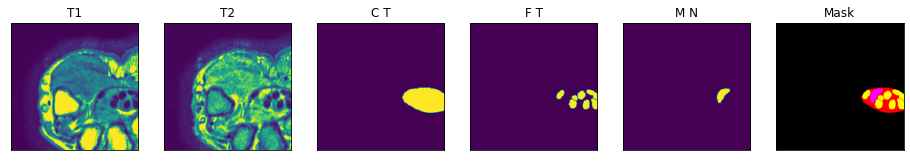

(320, 320, 2)


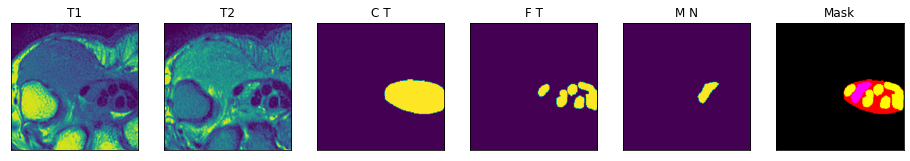

(320, 320, 2)


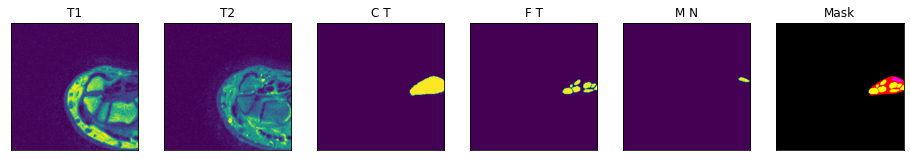

(320, 320, 2)


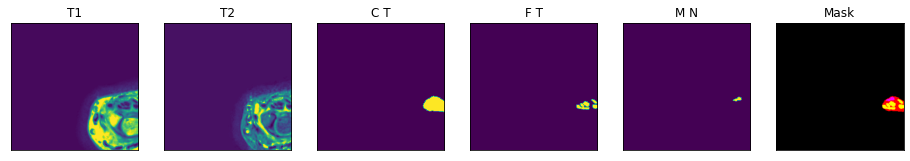

(320, 320, 2)


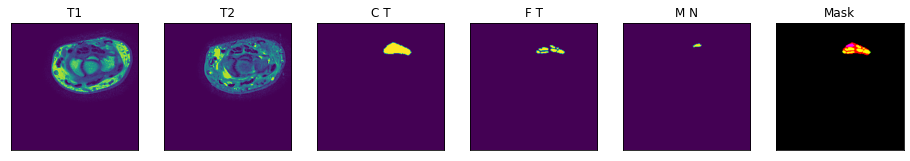

In [14]:
TrainSet = Dataset(image_path = {"T1":T1, "T2":T2},
          masks_path = {"CT":CT, "FT":FT, "MN":MN},
          augmentation=get_training_augmentation(),
          preprocessing=None,
          )
for i in range(0,5):
  image, mask = TrainSet[i] # get some sample
  print(image.shape)
  visualize(
    T1 = image[:,:,0],
    T2 = image[:,:,1],
    C_T = mask[:,:,0].squeeze(),
    F_T = mask[:,:,1].squeeze(),
    M_N = mask[:,:,2].squeeze(),
    MASK = mask
  )

# Train

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [16]:
from sklearn.model_selection import KFold
model = []
for fold in range(0,5):
  model.append(smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid'))

In [17]:
loss = smp.utils.losses.DiceLoss()
metrics = [ smp.utils.metrics.IoU(threshold=0.5), ]
optimizer = []
for fold in range(0,5):
  optimizer.append(torch.optim.Adam([ dict(params=model[fold].parameters(), lr=0.0001),]))

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = []
valid_epoch = []
for fold in range(0,5):
  train_epoch.append(
      smp.utils.train.TrainEpoch(
          model[fold],
          loss=loss,
          metrics=metrics,
          optimizer=optimizer[fold],
          device=DEVICE,
          verbose=True,
          )
      )

  valid_epoch.append(
      smp.utils.train.ValidEpoch(
          model[fold], 
          loss=loss, 
          metrics=metrics,
          device=DEVICE,
          verbose=True,
      )
  )

In [19]:
from torchsummary import summary

if torch.cuda.is_available():
  summary(model[0].cuda(), (2, 576, 576))
else:
  summary(model[0], (2, 576, 576))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 288, 288]           6,272
       BatchNorm2d-2         [-1, 64, 288, 288]             128
              ReLU-3         [-1, 64, 288, 288]               0
         MaxPool2d-4         [-1, 64, 144, 144]               0
            Conv2d-5         [-1, 64, 144, 144]          36,864
       BatchNorm2d-6         [-1, 64, 144, 144]             128
              ReLU-7         [-1, 64, 144, 144]               0
            Conv2d-8         [-1, 64, 144, 144]          36,864
       BatchNorm2d-9         [-1, 64, 144, 144]             128
             ReLU-10         [-1, 64, 144, 144]               0
       BasicBlock-11         [-1, 64, 144, 144]               0
           Conv2d-12         [-1, 64, 144, 144]          36,864
      BatchNorm2d-13         [-1, 64, 144, 144]             128
             ReLU-14         [-1, 64, 1

## K-fold Cross Validation

In [20]:
kf = KFold(n_splits=5,shuffle=False)

TrainData = np.array([T1,T2,CT,FT,MN])
TrainData = np.transpose(TrainData)
TestData = np.array([Test_T1,Test_T2,Test_CT,Test_FT,Test_MN])
TestData = np.transpose(TestData)
Train_loader = []
Valid_loader = []
for train_index , valid_index in kf.split(TrainData):
    max_score = 0
    TrainSet = Dataset(
              image_path = {"T1":T1[ train_index[0] : train_index[-1] ], "T2":T2[ train_index[0] : train_index[-1] ]},
              masks_path = {"CT":CT[ train_index[0] : train_index[-1] ], "FT":FT[ train_index[0] : train_index[-1] ], "MN":MN[ train_index[0] : train_index[-1] ]},
              augmentation=get_training_augmentation(),
              preprocessing=get_preprocessing(),
              )
    ValidSet = Dataset(
              image_path = {"T1":T1[ valid_index[0] : valid_index[-1] ], "T2":T2[ valid_index[0] : valid_index[-1] ]},
              masks_path = {"CT":CT[ valid_index[0] : valid_index[-1] ], "FT":FT[ valid_index[0] : valid_index[-1] ], "MN":MN[ valid_index[0] : valid_index[-1] ]},
              augmentation=get_validation_augmentation(),
              preprocessing=get_preprocessing(),
              )
    Train_loader.append(DataLoader(TrainSet, batch_size=8, shuffle=True, num_workers=12))
    Valid_loader.append(DataLoader(ValidSet, batch_size=1, shuffle=False, num_workers=4))

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

In [21]:
print(Valid_loader)
print(Train_loader)

[<torch.utils.data.dataloader.DataLoader object at 0x7f9e91214d90>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff0df10>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e902630d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff5bc10>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff5b450>]
[<torch.utils.data.dataloader.DataLoader object at 0x7f9e91214f90>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff0dd50>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e90263c90>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff5b590>, <torch.utils.data.dataloader.DataLoader object at 0x7f9e8ff5b1d0>]


In [22]:
 for fold in range(0,5):
    max_score = 0
    for epoch in range(0, 50):
      print('\nEpoch: {}'.format(epoch))
      train_logs = train_epoch[fold].run(Train_loader[fold])
      valid_logs = valid_epoch[fold].run(Valid_loader[fold])
      wandb.log({"EPOCHS":epoch,  "Train Loss (fold {})".format(fold):train_logs['dice_loss']})
      wandb.log({"EPOCHS":epoch,  "Train IoU　Score (fold {})".format(fold):train_logs['iou_score']})
      wandb.log({"EPOCHS":epoch,  "Valid Loss (fold {})".format(fold):valid_logs['dice_loss']})
      wandb.log({"EPOCHS":epoch,  "Valid IoU　Score (fold {})".format(fold):valid_logs['iou_score']})
      print(optimizer[fold].param_groups[0]['lr'])
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/best_model_{}.pth'.format(fold))
        print('Model saved!')
        print("max_score : ",max_score)
        
      if epoch == 25:
        optimizer[fold].param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid:   0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 37/37 [00:13<00:00,  2.77it/s, dice_loss - 0.97, iou_score - 0.02518]
0.0001
Model saved!
max_score :  0.02518123639999209

Epoch: 1
valid: 100%|██████████| 37/37 [00:02<00:00, 13.73it/s, dice_loss - 0.963, iou_score - 0.04272]
0.0001
Model saved!
max_score :  0.04272134048310486

Epoch: 2
valid: 100%|██████████| 37/37 [00:02<00:00, 14.07it/s, dice_loss - 0.9568, iou_score - 0.03766]
0.0001

Epoch: 3
valid: 100%|██████████| 37/37 [00:02<00:00, 13.44it/s, dice_loss - 0.9528, iou_score - 0.104]
0.0001
Model saved!
max_score :  0.10396293087585551

Epoch: 4
valid: 100%|██████████| 37/37 [00:02<00:00, 13.94it/s, dice_loss - 0.9457, iou_score - 0.1692]
0.0001
Model saved!
max_score :  0.16922606487531913

Epoch: 5
valid: 100%|██████████| 37/37 [00:02<00:00, 13.67it/s, dice_loss - 0.9416, iou_score - 0.2246]
0.0001
Model saved!
max_score :  0.22458801640046608

Epoch: 6
valid: 100%|██████████| 37/37 [00:02<00:00, 14.00it/s, dice_loss - 0.9377, iou_score - 0.1804]
0.00

In [23]:
wandb.finish()

EPOCHS,49
Train Loss (fold 0),0.2211
_runtime,9176
_timestamp,1626537929
_step,999
Train IoU Score (fold 0),0.7908
Valid Loss (fold 0),0.39548
Valid IoU Score (fold 0),0.71591
Train Loss (fold 1),0.15444
Train IoU Score (fold 1),0.8035
Valid Loss (fold 1),0.21142


EPOCHS,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
Train Loss (fold 0),████▇▇▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train IoU Score (fold 0),▁▁▁▂▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇██████████████████
Valid Loss (fold 0),████▇▇▇▇▇▇▇▆▆▇▅▅▃▂▂█▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Valid IoU Score (fold 0),▁▁▁▂▃▃▆▄▆▅▆▅▆▄▆▇▇█▇▁▆███████████████████
Train Loss (fold 1),██▇▇▇▆▆▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train IoU Score (fold 1),▁▂▃▃▄▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
Valid Loss (fold 1),███▇▇▇▇▇▆▆▅▅▄▅▃▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Test

In [39]:
Test_CT = []
Test_FT = []
Test_MN = []
Test_T1 = []
Test_T2 = []
for idx in range(9,10):
  data = Test_DIR + "/{}/".format(idx)
  Test_CT = Test_CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  Test_FT = Test_FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  Test_MN = Test_MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  Test_T1 = Test_T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  Test_T2 = Test_T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]
Test_CT.sort()
Test_FT.sort()
Test_MN.sort()
Test_T1.sort()
Test_T2.sort()

In [223]:
TestSet = Dataset(
              image_path = {"T1":Test_T1, "T2":Test_T2},
              masks_path = {"CT":Test_CT, "FT":Test_FT, "MN":Test_MN},
              augmentation=get_validation_augmentation(),
              preprocessing=get_preprocessing(),
              )
Test_all_loader = DataLoader(TestSet, batch_size=17, shuffle=True, num_workers=12)
Test_loader = DataLoader(TestSet, batch_size=1, shuffle=True, num_workers=12)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [224]:
Test_epoch = []
best_model = []
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]
#best_model = smp.UnetPlusPlus(encoder_weights=None, in_channels=2, classes=3, activation='sigmoid')
# evaluate model on test set
for fold in range(0,5):
  best_model.append(torch.load('/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/best_model_{}.pth'.format(fold)))
for fold in range(0,5):
  Test_epoch.append(
      smp.utils.train.ValidEpoch(
          best_model[fold][0],
          loss=loss,
          metrics=metrics,
          device=DEVICE,
          )
      )
  print("fold {}".format(fold))

fold 0
fold 1
fold 2
fold 3
fold 4


In [225]:
for fold in range(0,5):
  print("fold : {}".format(fold))
  logs = Test_epoch[fold].run(Test_all_loader)

fold : 0
valid:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it, dice_loss - 0.399, fscore - 0.842]
fold : 1
valid: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it, dice_loss - 0.3872, fscore - 0.8582]
fold : 2
valid: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it, dice_loss - 0.3967, fscore - 0.8373]
fold : 3
valid: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it, dice_loss - 0.378, fscore - 0.879]
fold : 4
valid: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it, dice_loss - 0.3878, fscore - 0.8444]


In [217]:
def IoU_2D(mask1,mask2):
  mask = (mask1 + mask2)/2
  mask_bound = 0
  mask1_bound = 0
  mask2_bound = 0
  for X in mask:
    for Y in X:
      if Y > 0.5:
        mask_bound = mask_bound + 1
  for X in mask1:
    for Y in X:
      if Y > 0.5:
        mask1_bound = mask1_bound + 1
  for X in mask2:
    for Y in X:
      if Y > 0.5:
        mask2_bound = mask2_bound + 1
  union = (mask1_bound + mask2_bound) - mask_bound
  IoU = 0.0
  IoU = mask_bound / union
  Dice = mask_bound * 2/(mask1_bound + mask2_bound)
  return IoU, Dice

fold =  0
picture =  0
CT IoU  Score = 0.7153614457831325
CT Dice Score = 0.8340649692712906
FT IoU  Score = 0.7577399380804953
FT Dice Score = 0.8621752531924263
MN IoU  Score = 0.0
MN Dice Score = 0.0


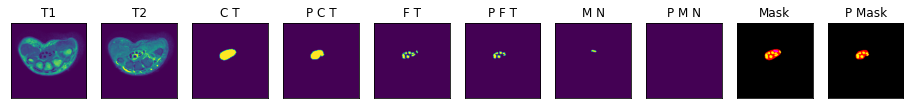

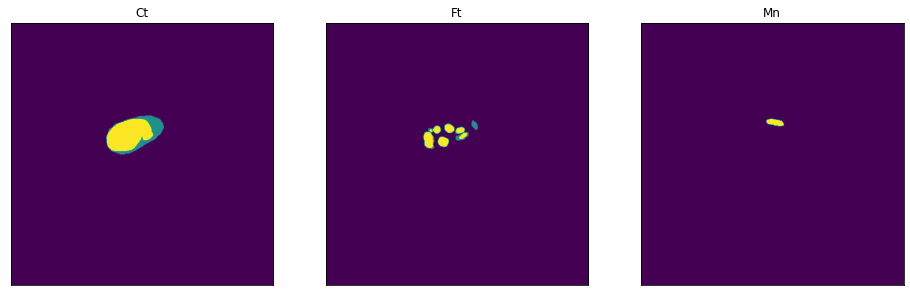

picture =  1
CT IoU  Score = 0.7631734754292481
CT Dice Score = 0.8656816655473473
FT IoU  Score = 0.8322456813819578
FT Dice Score = 0.9084433270479783
MN IoU  Score = 0.17980295566502463
MN Dice Score = 0.3048016701461378


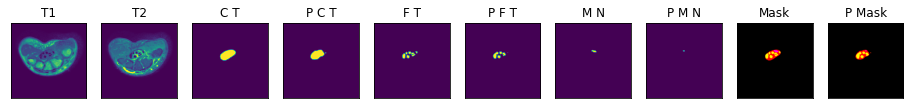

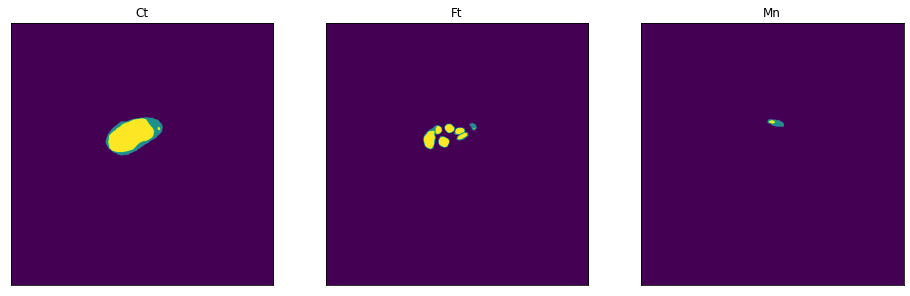

picture =  2
CT IoU  Score = 0.8252246143414138
CT Dice Score = 0.9042444506362032
FT IoU  Score = 0.8251681075888568
FT Dice Score = 0.9042105263157895
MN IoU  Score = 0.0
MN Dice Score = 0.0


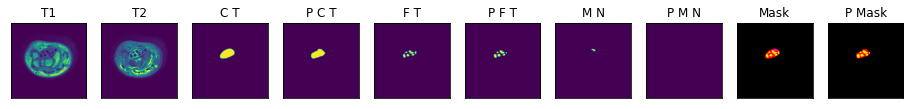

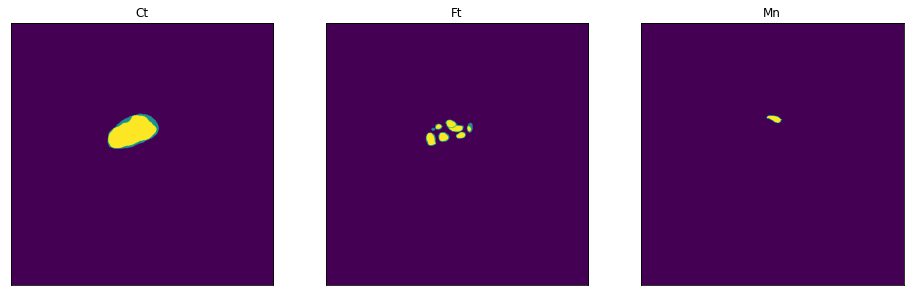

picture =  3
CT IoU  Score = 0.9052558782849239
CT Dice Score = 0.9502722323049002
FT IoU  Score = 0.8673469387755102
FT Dice Score = 0.9289617486338798
MN IoU  Score = 0.0
MN Dice Score = 0.0


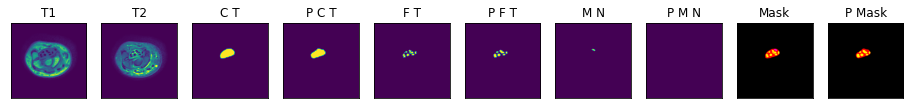

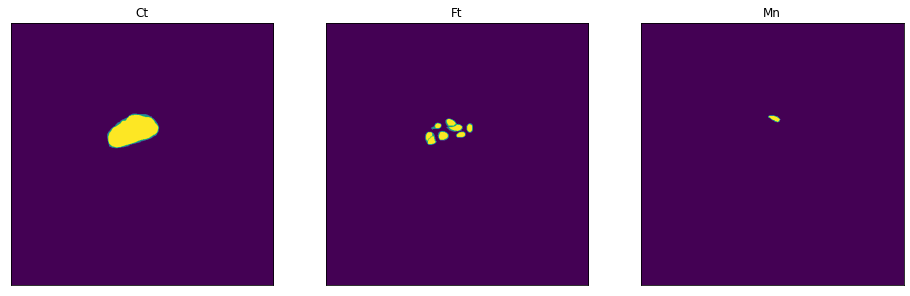

picture =  4
CT IoU  Score = 0.9266459728802483
CT Dice Score = 0.9619265666073095
FT IoU  Score = 0.8603082851637764
FT Dice Score = 0.9249093733816676
MN IoU  Score = 0.0
MN Dice Score = 0.0


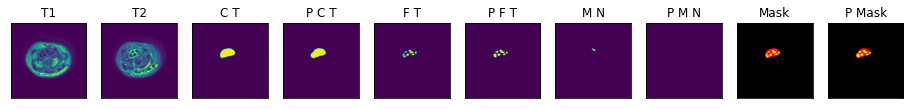

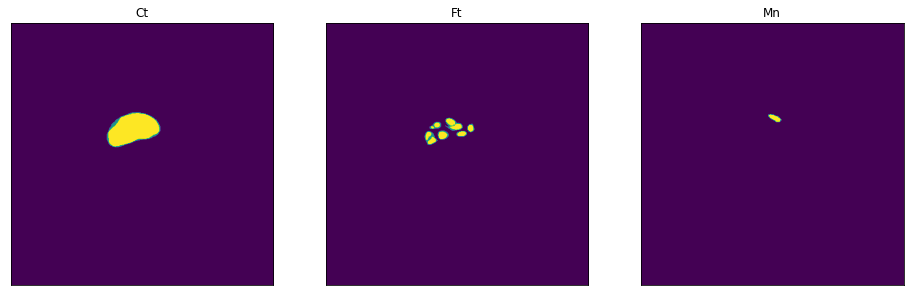

picture =  5
CT IoU  Score = 0.9248597578978447
CT Dice Score = 0.9609632640539919
FT IoU  Score = 0.8696982947092261
FT Dice Score = 0.9303086997193639
MN IoU  Score = 0.0
MN Dice Score = 0.0


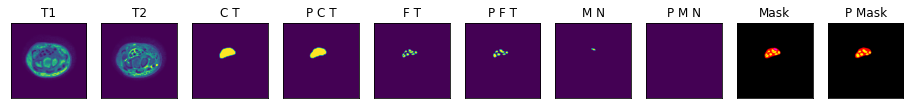

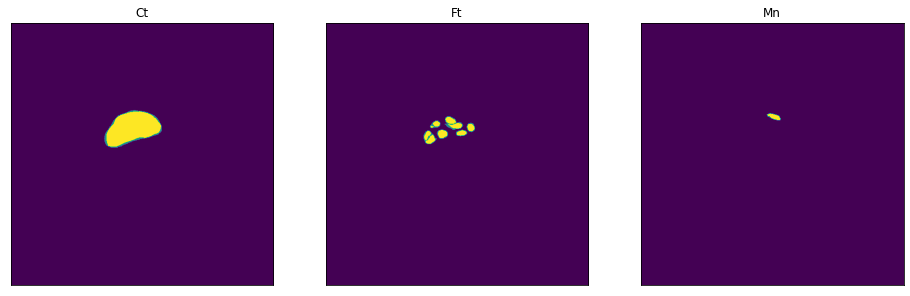

picture =  6
CT IoU  Score = 0.9380917698470502
CT Dice Score = 0.9680571213829388
FT IoU  Score = 0.8670572329878323
FT Dice Score = 0.9287955587738354
MN IoU  Score = 0.0
MN Dice Score = 0.0


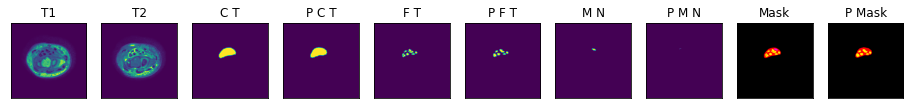

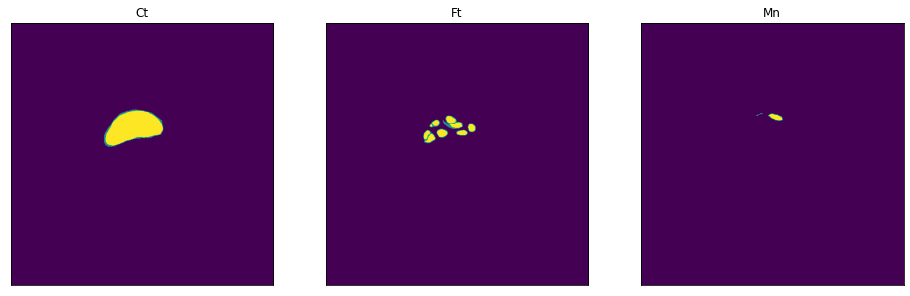

picture =  7
CT IoU  Score = 0.8099484464260833
CT Dice Score = 0.8949961508852964
FT IoU  Score = 0.8120404411764706
FT Dice Score = 0.8962718742074562
MN IoU  Score = 0.0
MN Dice Score = 0.0


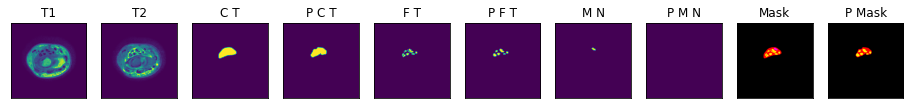

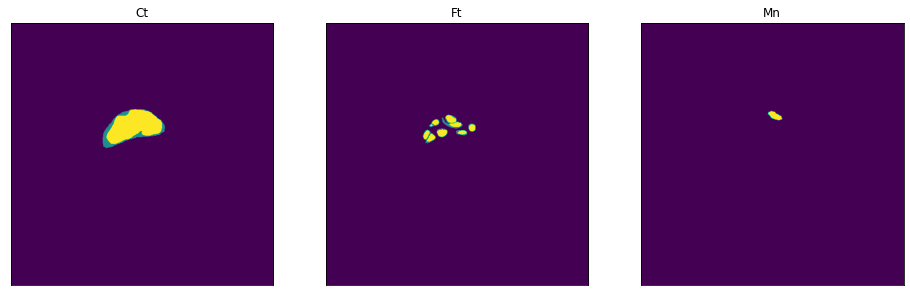

picture =  8
CT IoU  Score = 0.7891466445733223
CT Dice Score = 0.8821486455197962
FT IoU  Score = 0.7502145922746781
FT Dice Score = 0.8572829818538499
MN IoU  Score = 0.0
MN Dice Score = 0.0


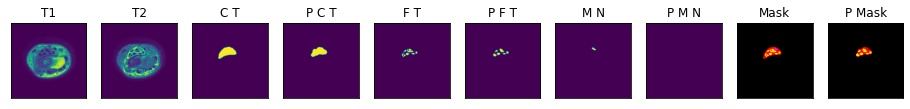

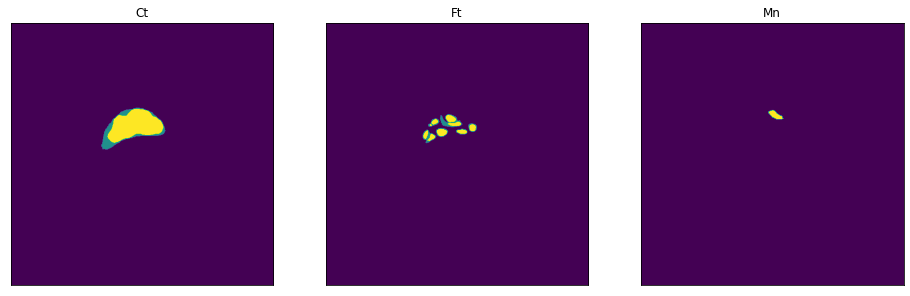

picture =  9
CT IoU  Score = 0.7693773824650572
CT Dice Score = 0.8696588868940754
FT IoU  Score = 0.674644467568505
FT Dice Score = 0.8057166528583264
MN IoU  Score = 0.0
MN Dice Score = 0.0


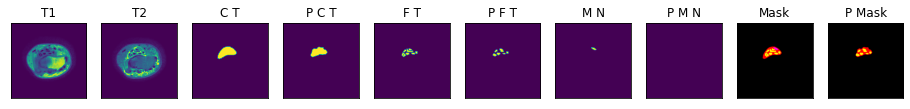

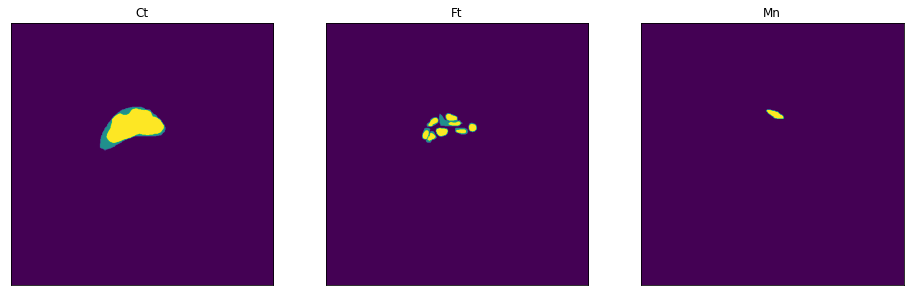

picture =  10
CT IoU  Score = 0.8226585130350821
CT Dice Score = 0.9027017481900053
FT IoU  Score = 0.8403896590483327
FT Dice Score = 0.9132736156351792
MN IoU  Score = 0.12386706948640483
MN Dice Score = 0.22043010752688172


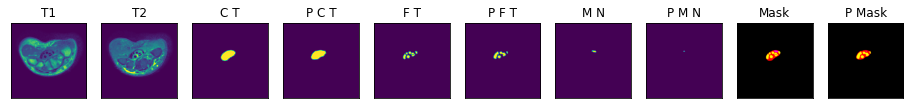

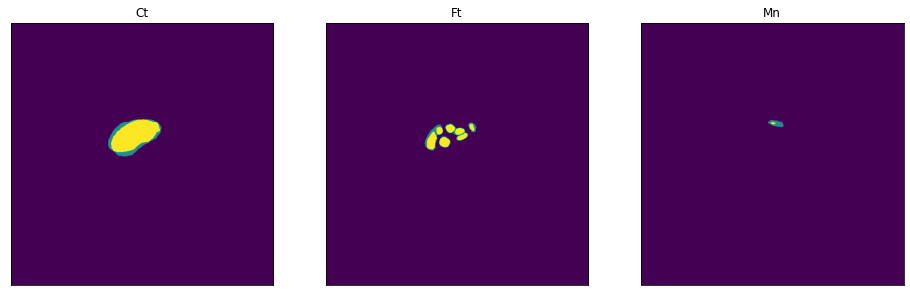

picture =  11
CT IoU  Score = 0.8892988929889298
CT Dice Score = 0.94140625
FT IoU  Score = 0.8534307754770605
FT Dice Score = 0.9209200438116101
MN IoU  Score = 0.0
MN Dice Score = 0.0


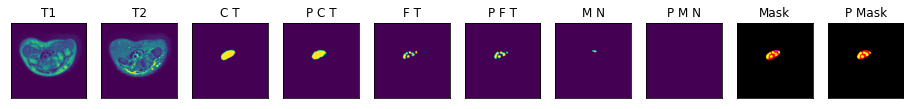

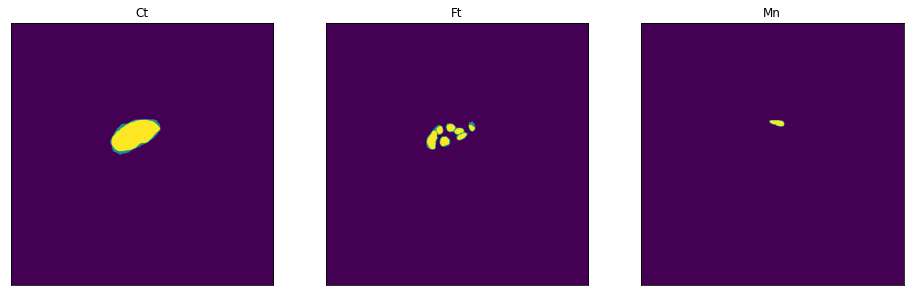

picture =  12
CT IoU  Score = 0.8319773611602406
CT Dice Score = 0.9082834524039389
FT IoU  Score = 0.8708757637474541
FT Dice Score = 0.9309819290224254
MN IoU  Score = 0.0
MN Dice Score = 0.0


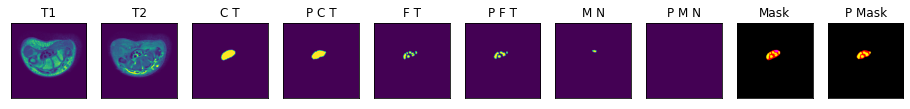

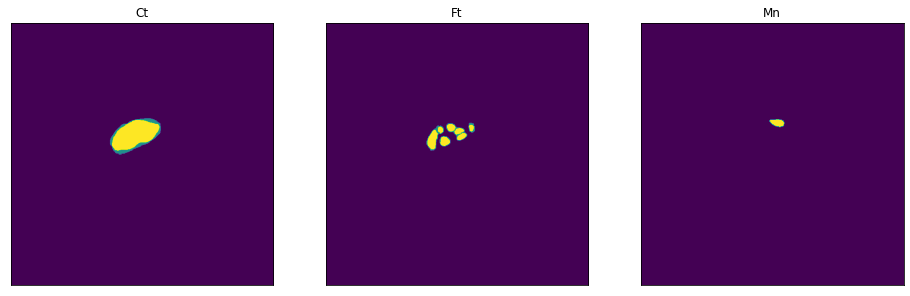

picture =  13
CT IoU  Score = 0.8617857142857143
CT Dice Score = 0.9257625167849607
FT IoU  Score = 0.8606986899563319
FT Dice Score = 0.9251349448486271
MN IoU  Score = 0.0
MN Dice Score = 0.0


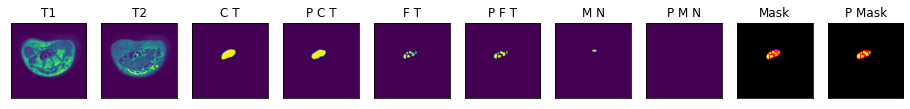

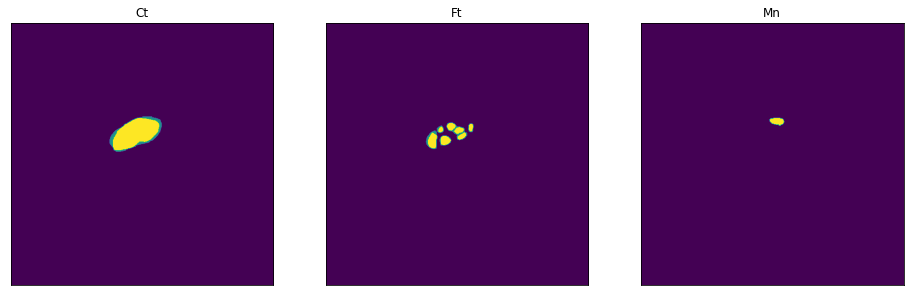

picture =  14
CT IoU  Score = 0.8396366332962552
CT Dice Score = 0.9128287816184621
FT IoU  Score = 0.83429076447194
FT Dice Score = 0.9096603228137798
MN IoU  Score = 0.0
MN Dice Score = 0.0


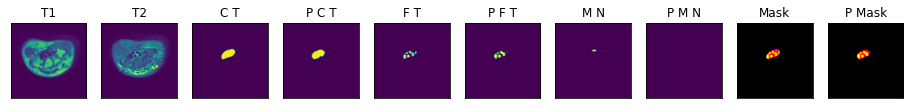

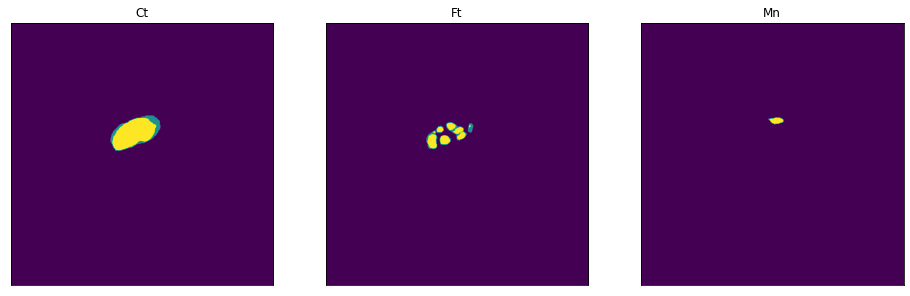

picture =  15
CT IoU  Score = 0.8965397923875432
CT Dice Score = 0.9454479109651523
FT IoU  Score = 0.8222904782799474
FT Dice Score = 0.9024801348422827
MN IoU  Score = 0.0
MN Dice Score = 0.0


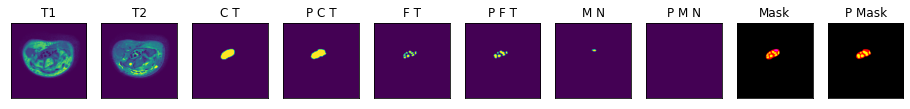

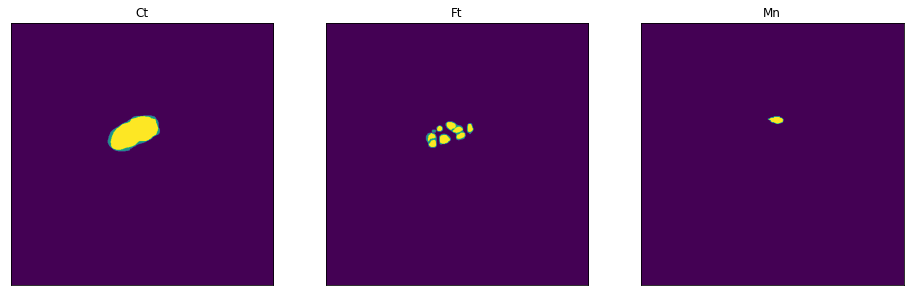

picture =  16
CT IoU  Score = 0.8032093105272439
CT Dice Score = 0.8908664189321338
FT IoU  Score = 0.8090737240075614
FT Dice Score = 0.8944618599791013
MN IoU  Score = 0.0
MN Dice Score = 0.0


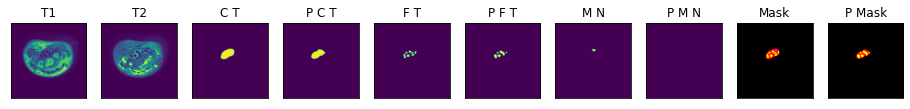

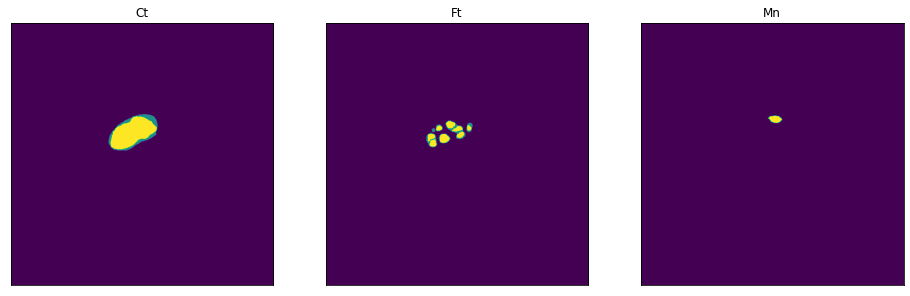

picture =  17
CT IoU  Score = 0.838285519125683
CT Dice Score = 0.9120297259637715
FT IoU  Score = 0.8121387283236994
FT Dice Score = 0.8963317384370016
MN IoU  Score = 0.0
MN Dice Score = 0.0


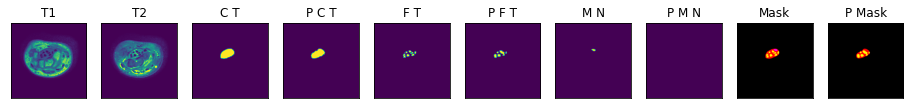

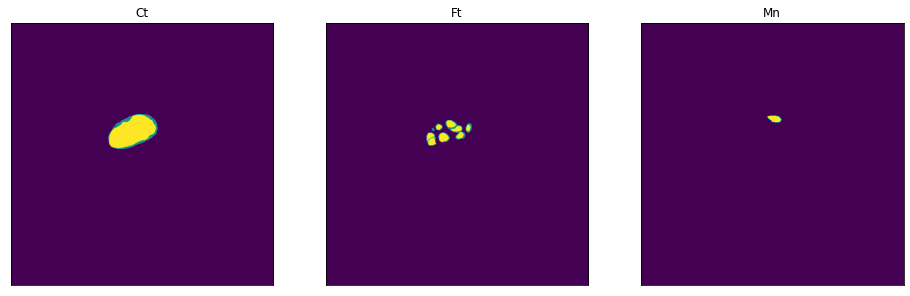

fold =  1
picture =  0
CT IoU  Score = 0.7099821990962618
CT Dice Score = 0.8303971812940423
FT IoU  Score = 0.7720446669233731
FT Dice Score = 0.8713602781399391
MN IoU  Score = 0.0
MN Dice Score = 0.0


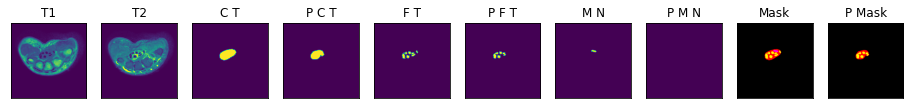

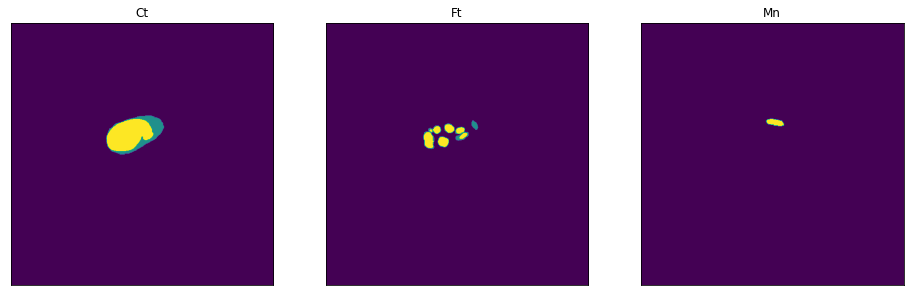

picture =  1
CT IoU  Score = 0.7575081772227178
CT Dice Score = 0.8620252093731495
FT IoU  Score = 0.8441210264266564
FT Dice Score = 0.915472481827622
MN IoU  Score = 0.054187192118226604
MN Dice Score = 0.102803738317757


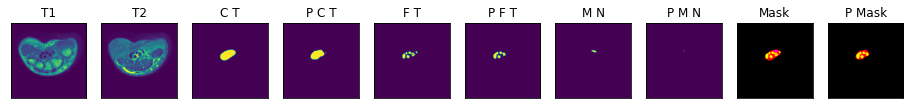

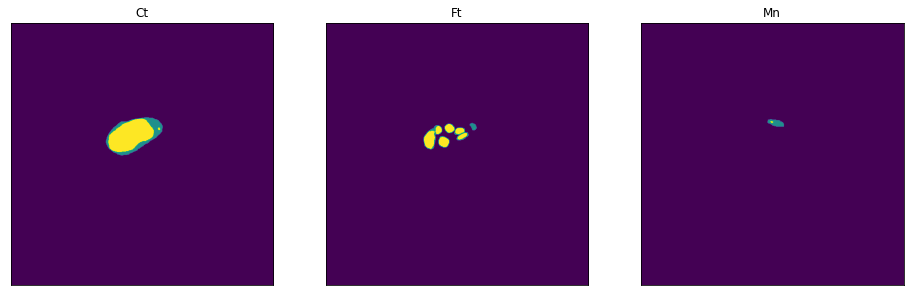

picture =  2
CT IoU  Score = 0.7902869757174393
CT Dice Score = 0.8828606658446363
FT IoU  Score = 0.8091168091168092
FT Dice Score = 0.8944881889763779
MN IoU  Score = 0.0
MN Dice Score = 0.0


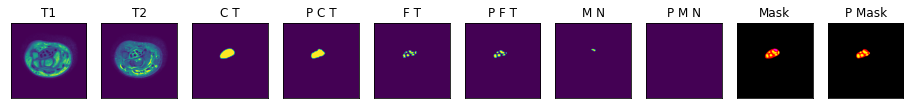

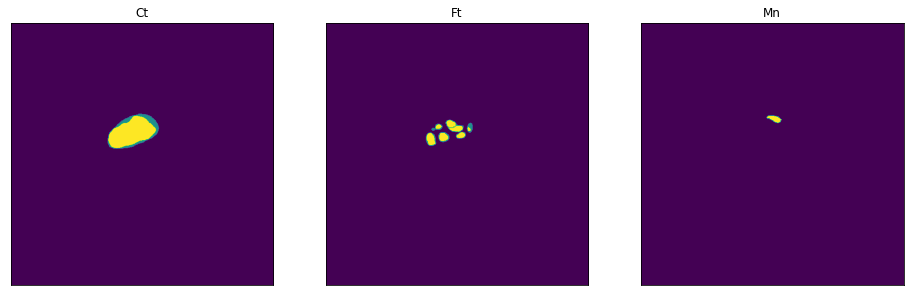

picture =  3
CT IoU  Score = 0.8873483535528596
CT Dice Score = 0.9403122130394858
FT IoU  Score = 0.8639423076923077
FT Dice Score = 0.9270054165591952
MN IoU  Score = 0.0
MN Dice Score = 0.0


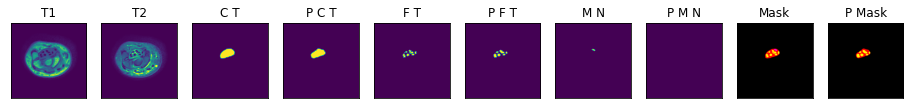

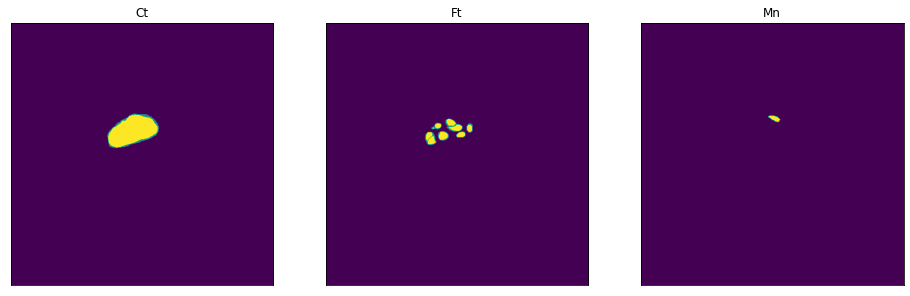

picture =  4
CT IoU  Score = 0.9167348274169802
CT Dice Score = 0.9565588461210207
FT IoU  Score = 0.8689458689458689
FT Dice Score = 0.9298780487804879
MN IoU  Score = 0.0
MN Dice Score = 0.0


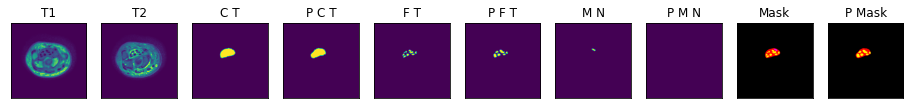

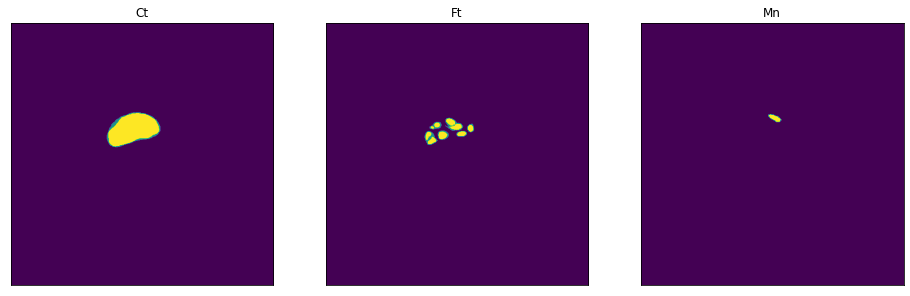

picture =  5
CT IoU  Score = 0.9193667702322829
CT Dice Score = 0.9579896708548524
FT IoU  Score = 0.8771626297577855
FT Dice Score = 0.9345622119815669
MN IoU  Score = 0.0
MN Dice Score = 0.0


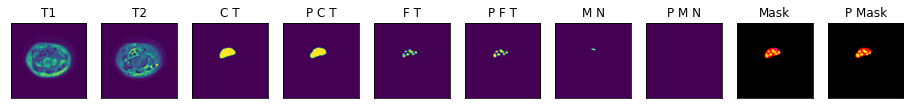

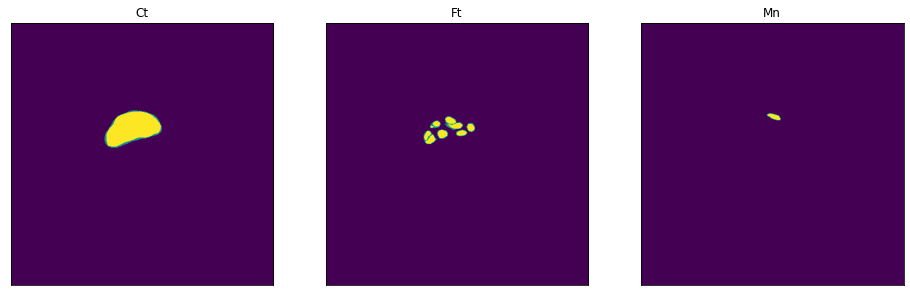

picture =  6
CT IoU  Score = 0.9352727272727273
CT Dice Score = 0.966553927095077
FT IoU  Score = 0.8831111111111111
FT Dice Score = 0.9379277790889781
MN IoU  Score = 0.0
MN Dice Score = 0.0


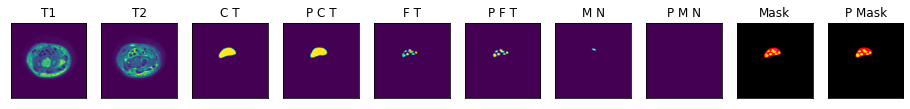

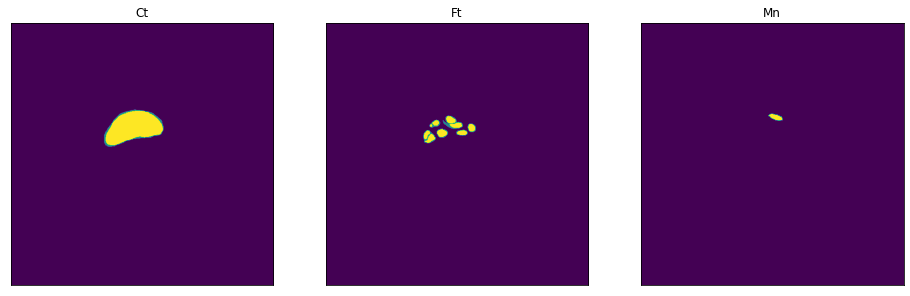

picture =  7
CT IoU  Score = 0.7935645633096532
CT Dice Score = 0.8849021435228331
FT IoU  Score = 0.8294573643410853
FT Dice Score = 0.9067796610169492
MN IoU  Score = 0.0
MN Dice Score = 0.0


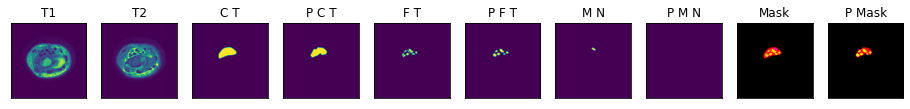

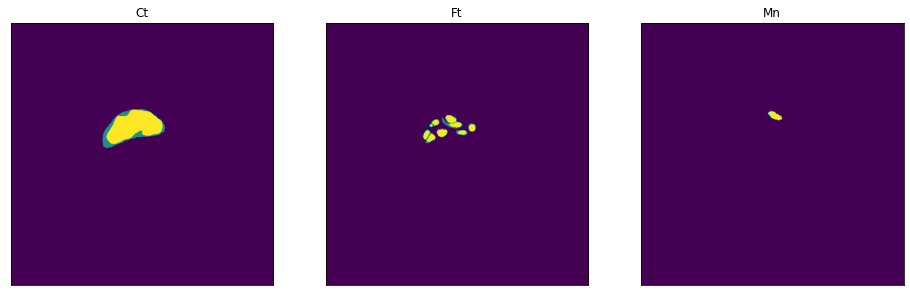

picture =  8
CT IoU  Score = 0.7740955537144435
CT Dice Score = 0.8726650062266501
FT IoU  Score = 0.768122085629504
FT Dice Score = 0.8688563893550707
MN IoU  Score = 0.0
MN Dice Score = 0.0


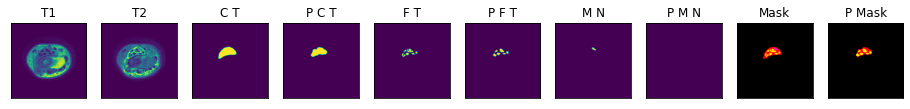

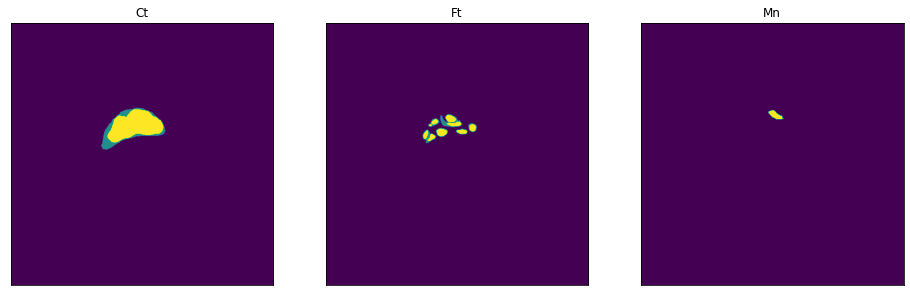

picture =  9
CT IoU  Score = 0.7681656504065041
CT Dice Score = 0.868884258926647
FT IoU  Score = 0.6943487250172296
FT Dice Score = 0.8196054504779337
MN IoU  Score = 0.0
MN Dice Score = 0.0


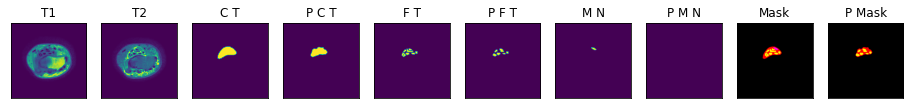

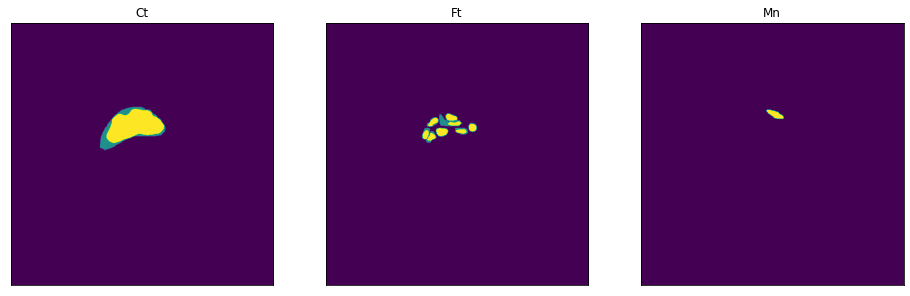

picture =  10
CT IoU  Score = 0.8225024248302619
CT Dice Score = 0.9026077700904737
FT IoU  Score = 0.8614751029576937
FT Dice Score = 0.9255832662912309
MN IoU  Score = 0.0
MN Dice Score = 0.0


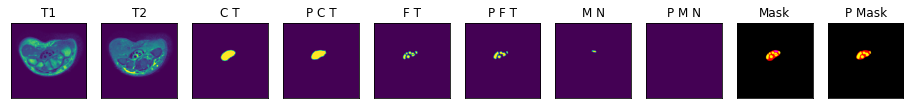

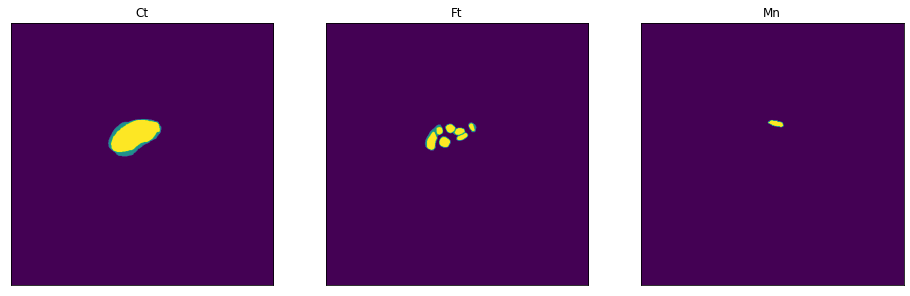

picture =  11
CT IoU  Score = 0.8840980283766353
CT Dice Score = 0.9384841075794621
FT IoU  Score = 0.8521183053557154
FT Dice Score = 0.9201553733275788
MN IoU  Score = 0.0
MN Dice Score = 0.0


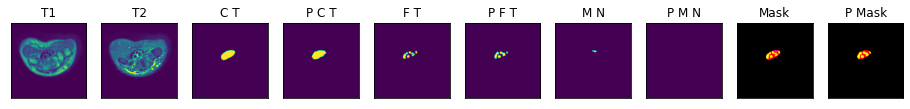

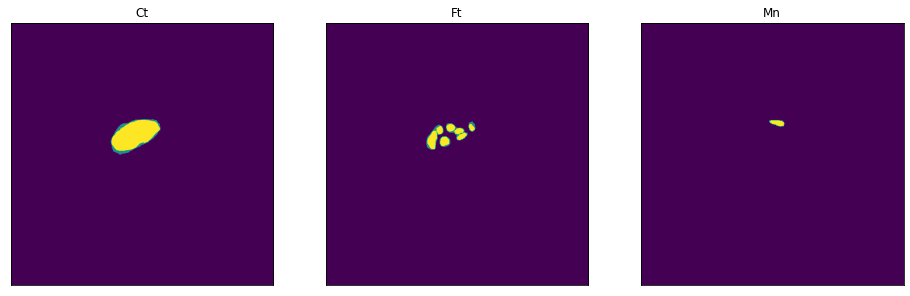

picture =  12
CT IoU  Score = 0.8143009605122732
CT Dice Score = 0.8976470588235295
FT IoU  Score = 0.8737745098039216
FT Dice Score = 0.9326357096141269
MN IoU  Score = 0.0
MN Dice Score = 0.0


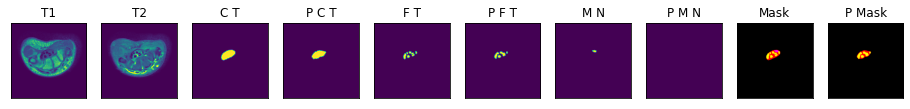

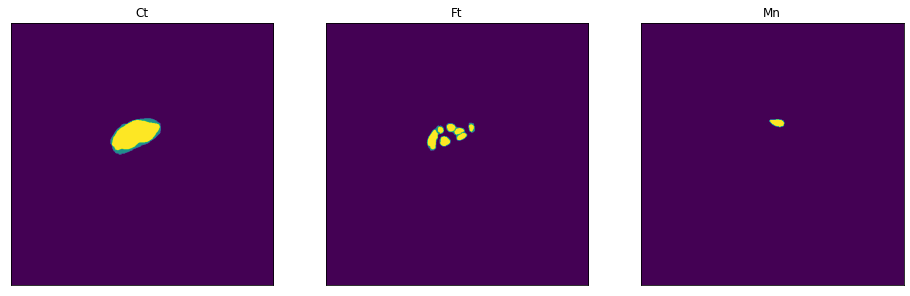

picture =  13
CT IoU  Score = 0.8265656018769175
CT Dice Score = 0.9050489082106511
FT IoU  Score = 0.8712389380530974
FT Dice Score = 0.9311894064790731
MN IoU  Score = 0.0
MN Dice Score = 0.0


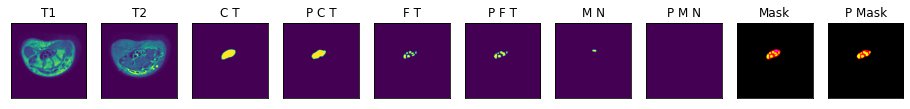

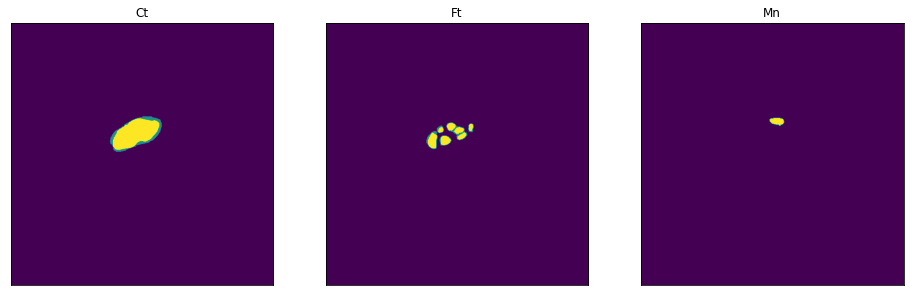

picture =  14
CT IoU  Score = 0.8009514747859182
CT Dice Score = 0.8894759087066779
FT IoU  Score = 0.7966636609558161
FT Dice Score = 0.8868255959849436
MN IoU  Score = 0.0
MN Dice Score = 0.0


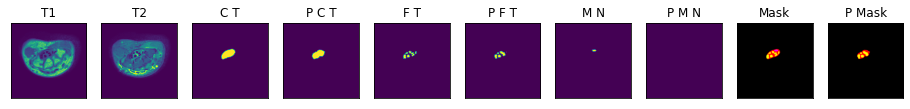

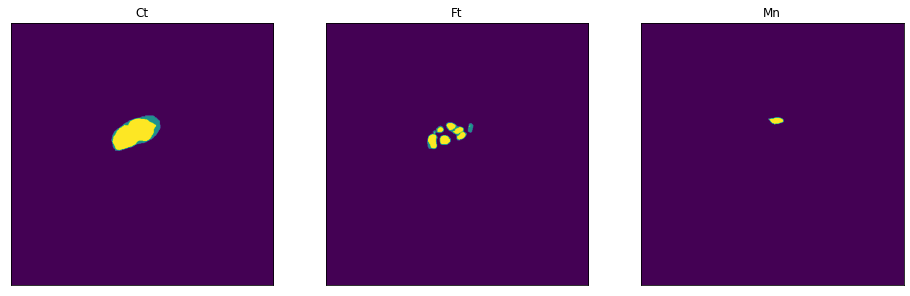

picture =  15
CT IoU  Score = 0.8856191977579261
CT Dice Score = 0.9393404551788203
FT IoU  Score = 0.821664464993395
FT Dice Score = 0.902102973168963
MN IoU  Score = 0.0
MN Dice Score = 0.0


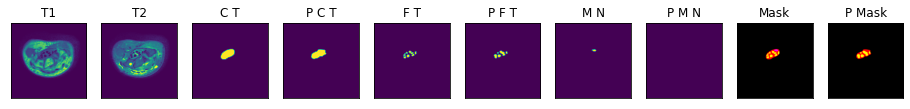

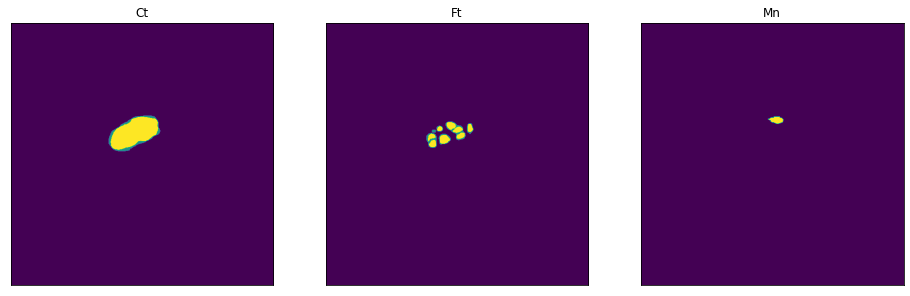

picture =  16
CT IoU  Score = 0.7304763591287409
CT Dice Score = 0.8442488743348342
FT IoU  Score = 0.7511825922421949
FT Dice Score = 0.857914640734738
MN IoU  Score = 0.0
MN Dice Score = 0.0


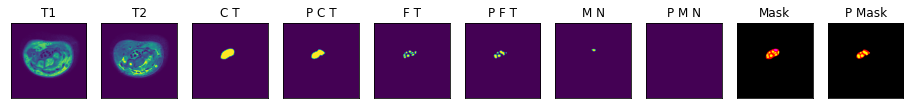

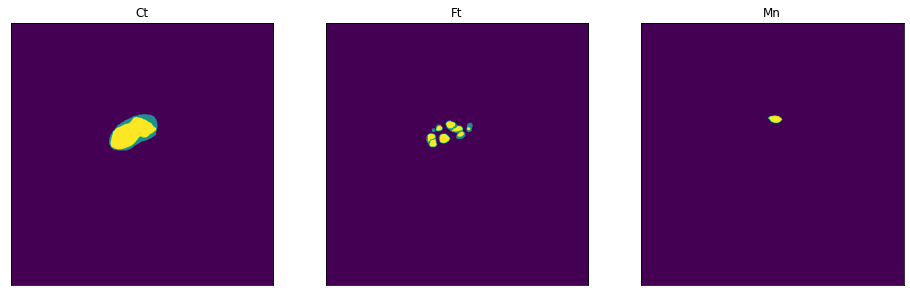

picture =  17
CT IoU  Score = 0.7866575201509175
CT Dice Score = 0.8805912843156076
FT IoU  Score = 0.7783086478738652
FT Dice Score = 0.8753358409457281
MN IoU  Score = 0.0
MN Dice Score = 0.0


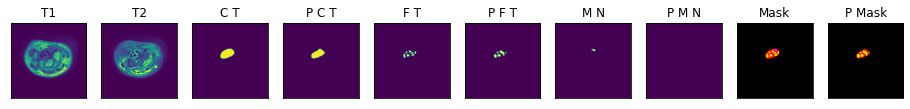

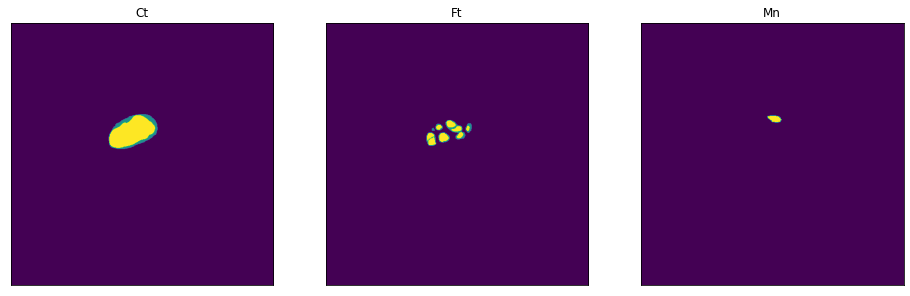

fold =  2
picture =  0
CT IoU  Score = 0.7099821990962618
CT Dice Score = 0.8303971812940423
FT IoU  Score = 0.7720446669233731
FT Dice Score = 0.8713602781399391
MN IoU  Score = 0.0
MN Dice Score = 0.0


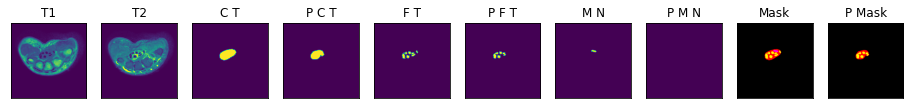

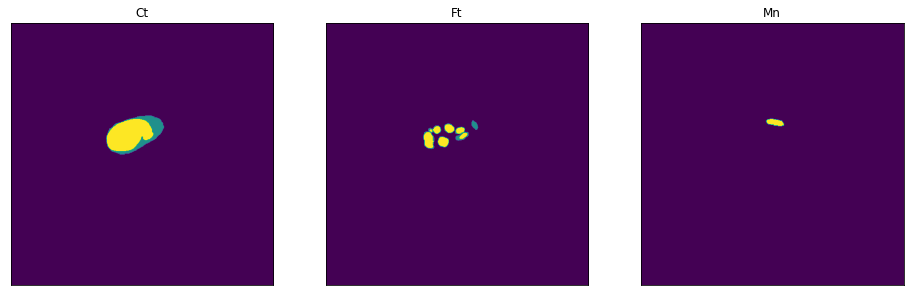

picture =  1
CT IoU  Score = 0.7575081772227178
CT Dice Score = 0.8620252093731495
FT IoU  Score = 0.8441210264266564
FT Dice Score = 0.915472481827622
MN IoU  Score = 0.054187192118226604
MN Dice Score = 0.102803738317757


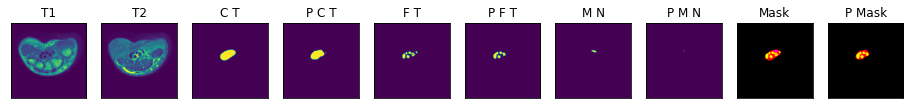

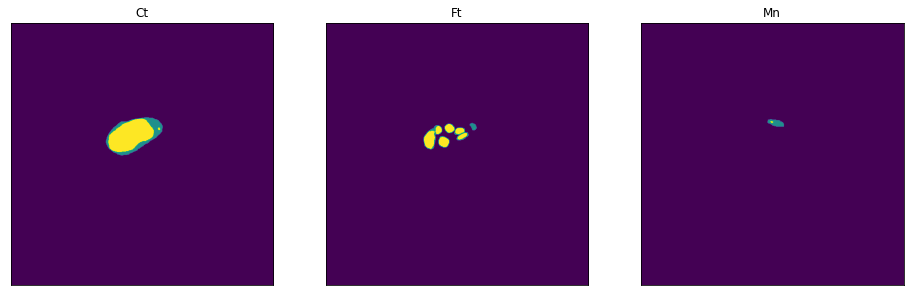

picture =  2
CT IoU  Score = 0.7902869757174393
CT Dice Score = 0.8828606658446363
FT IoU  Score = 0.8091168091168092
FT Dice Score = 0.8944881889763779
MN IoU  Score = 0.0
MN Dice Score = 0.0


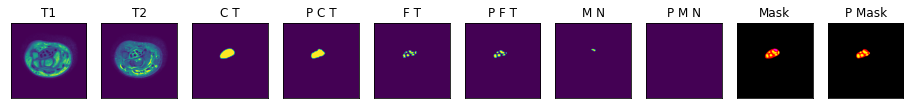

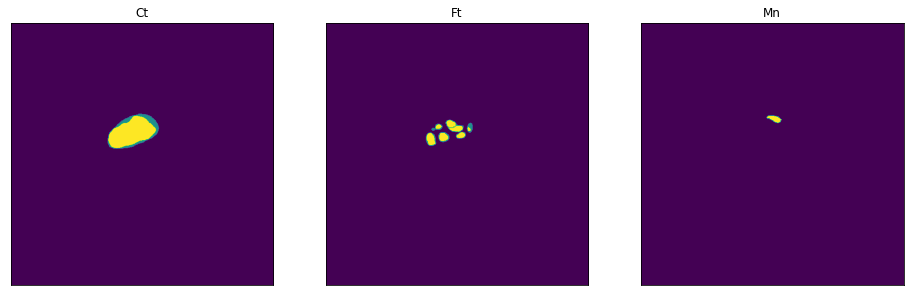

picture =  3
CT IoU  Score = 0.8873483535528596
CT Dice Score = 0.9403122130394858
FT IoU  Score = 0.8639423076923077
FT Dice Score = 0.9270054165591952
MN IoU  Score = 0.0
MN Dice Score = 0.0


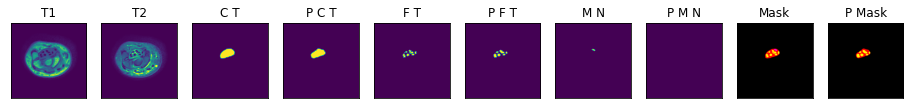

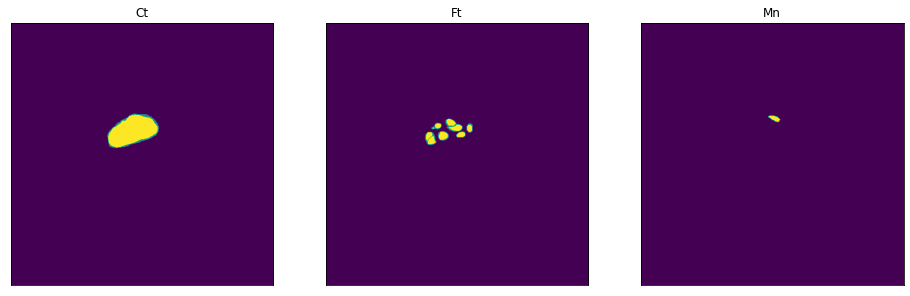

picture =  4
CT IoU  Score = 0.9167348274169802
CT Dice Score = 0.9565588461210207
FT IoU  Score = 0.8689458689458689
FT Dice Score = 0.9298780487804879
MN IoU  Score = 0.0
MN Dice Score = 0.0


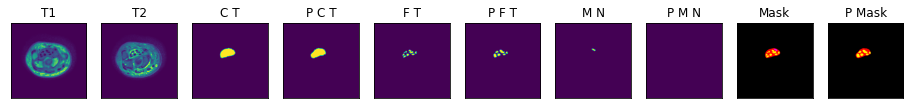

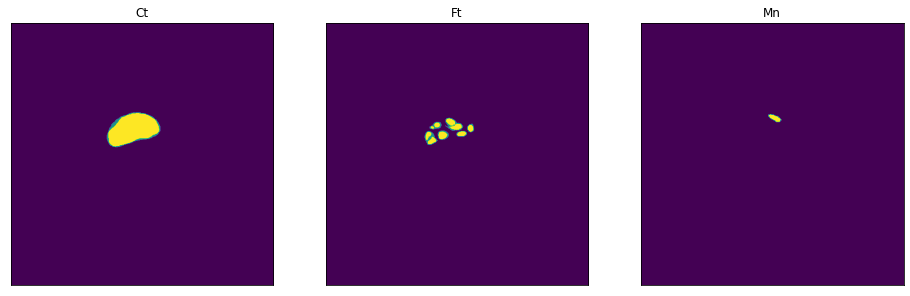

picture =  5
CT IoU  Score = 0.9193667702322829
CT Dice Score = 0.9579896708548524
FT IoU  Score = 0.8771626297577855
FT Dice Score = 0.9345622119815669
MN IoU  Score = 0.0
MN Dice Score = 0.0


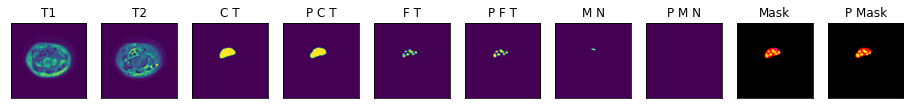

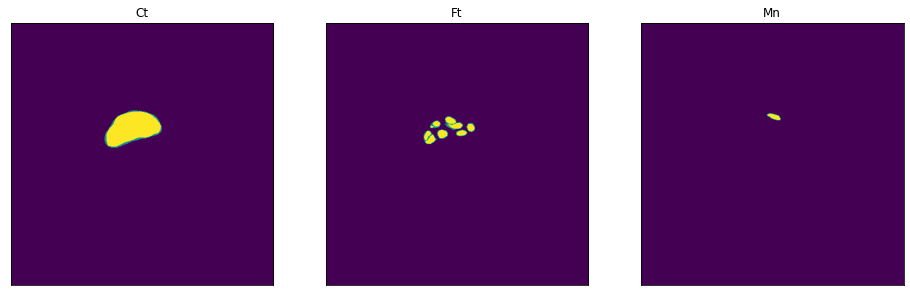

picture =  6
CT IoU  Score = 0.9352727272727273
CT Dice Score = 0.966553927095077
FT IoU  Score = 0.8831111111111111
FT Dice Score = 0.9379277790889781
MN IoU  Score = 0.0
MN Dice Score = 0.0


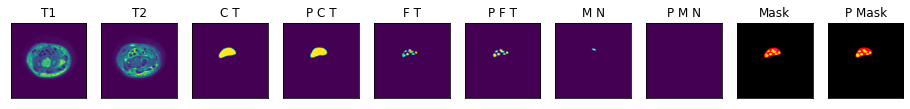

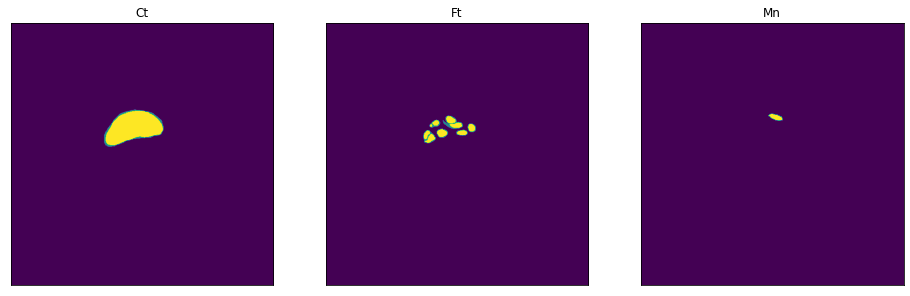

picture =  7
CT IoU  Score = 0.7935645633096532
CT Dice Score = 0.8849021435228331
FT IoU  Score = 0.8294573643410853
FT Dice Score = 0.9067796610169492
MN IoU  Score = 0.0
MN Dice Score = 0.0


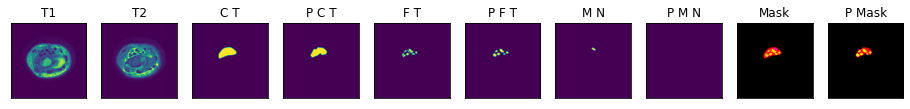

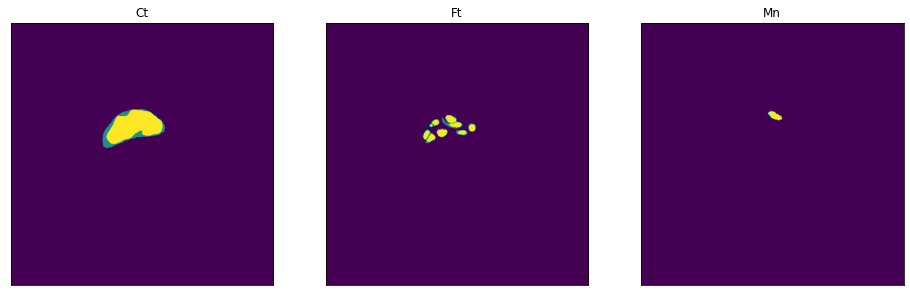

picture =  8
CT IoU  Score = 0.7740955537144435
CT Dice Score = 0.8726650062266501
FT IoU  Score = 0.768122085629504
FT Dice Score = 0.8688563893550707
MN IoU  Score = 0.0
MN Dice Score = 0.0


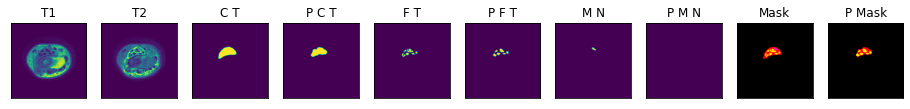

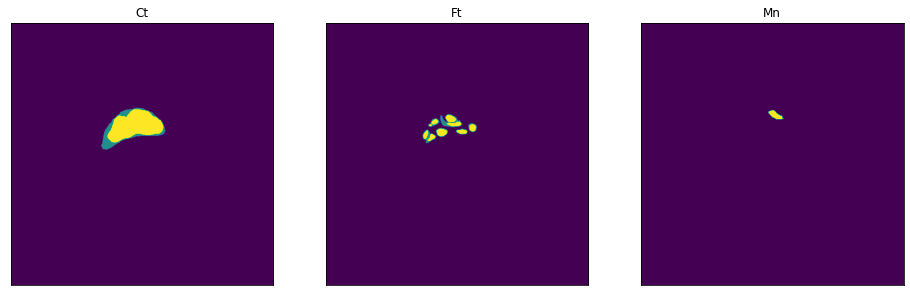

picture =  9
CT IoU  Score = 0.7681656504065041
CT Dice Score = 0.868884258926647
FT IoU  Score = 0.6943487250172296
FT Dice Score = 0.8196054504779337
MN IoU  Score = 0.0
MN Dice Score = 0.0


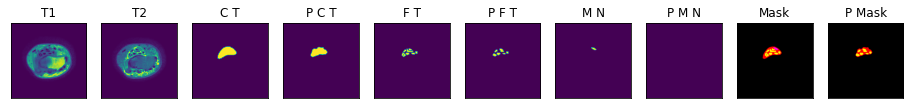

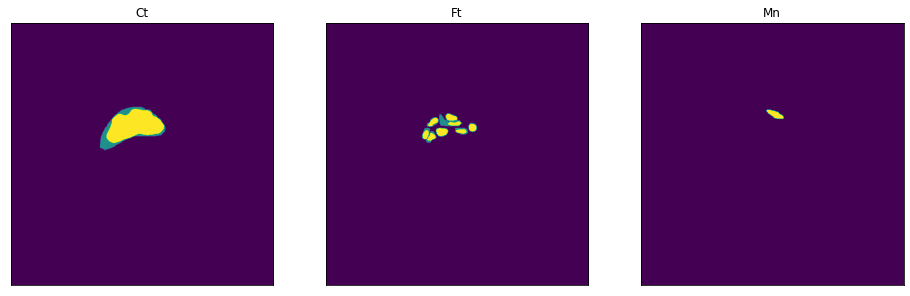

picture =  10
CT IoU  Score = 0.8225024248302619
CT Dice Score = 0.9026077700904737
FT IoU  Score = 0.8614751029576937
FT Dice Score = 0.9255832662912309
MN IoU  Score = 0.0
MN Dice Score = 0.0


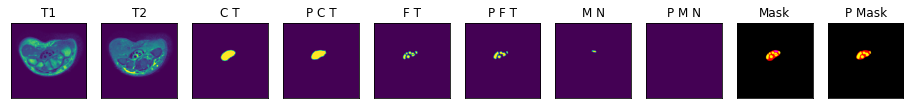

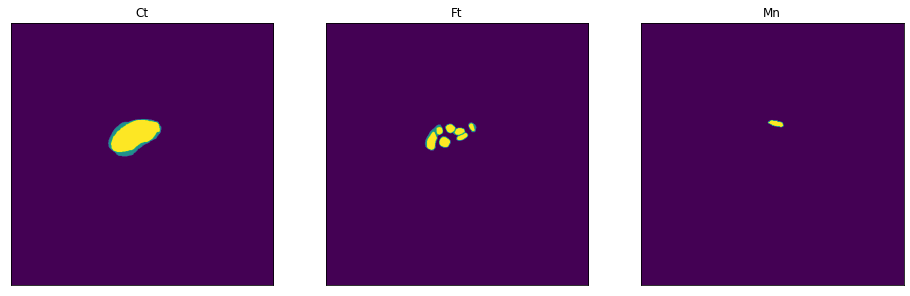

picture =  11
CT IoU  Score = 0.8840980283766353
CT Dice Score = 0.9384841075794621
FT IoU  Score = 0.8521183053557154
FT Dice Score = 0.9201553733275788
MN IoU  Score = 0.0
MN Dice Score = 0.0


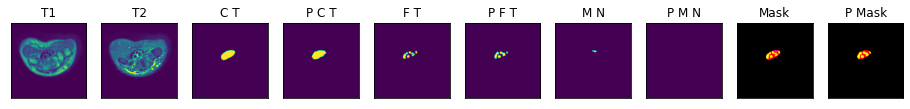

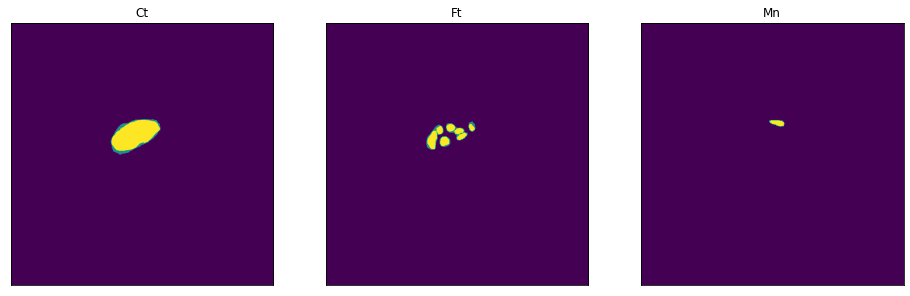

picture =  12
CT IoU  Score = 0.8143009605122732
CT Dice Score = 0.8976470588235295
FT IoU  Score = 0.8737745098039216
FT Dice Score = 0.9326357096141269
MN IoU  Score = 0.0
MN Dice Score = 0.0


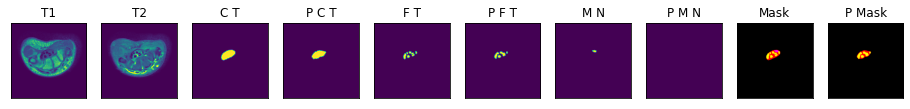

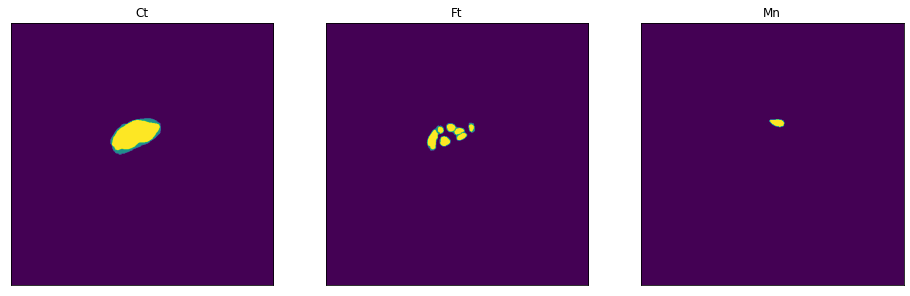

picture =  13
CT IoU  Score = 0.8265656018769175
CT Dice Score = 0.9050489082106511
FT IoU  Score = 0.8712389380530974
FT Dice Score = 0.9311894064790731
MN IoU  Score = 0.0
MN Dice Score = 0.0


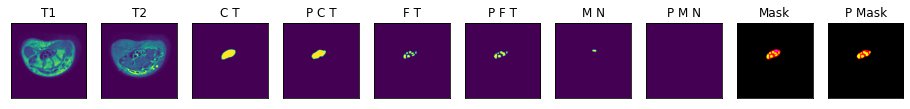

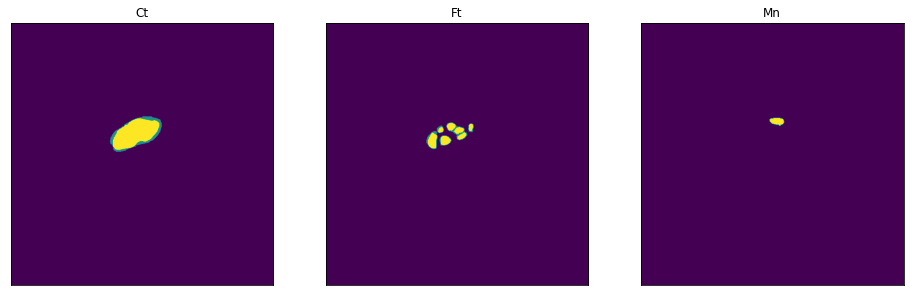

picture =  14
CT IoU  Score = 0.8009514747859182
CT Dice Score = 0.8894759087066779
FT IoU  Score = 0.7966636609558161
FT Dice Score = 0.8868255959849436
MN IoU  Score = 0.0
MN Dice Score = 0.0


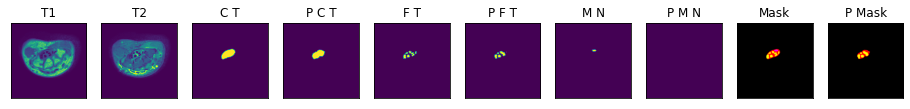

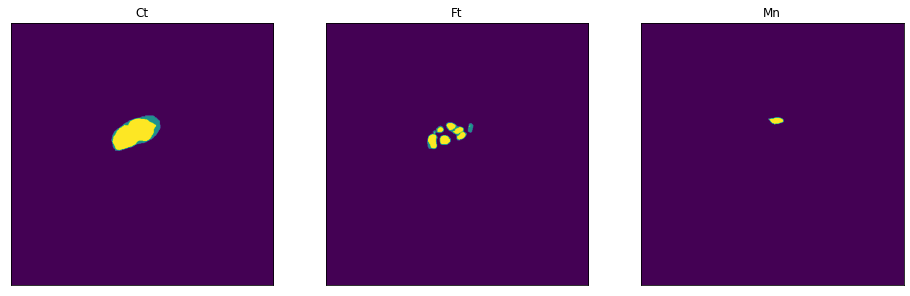

picture =  15
CT IoU  Score = 0.8856191977579261
CT Dice Score = 0.9393404551788203
FT IoU  Score = 0.821664464993395
FT Dice Score = 0.902102973168963
MN IoU  Score = 0.0
MN Dice Score = 0.0


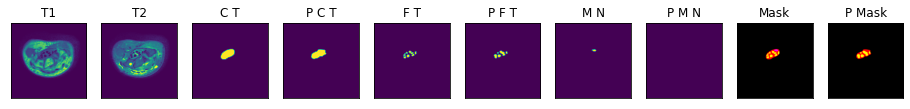

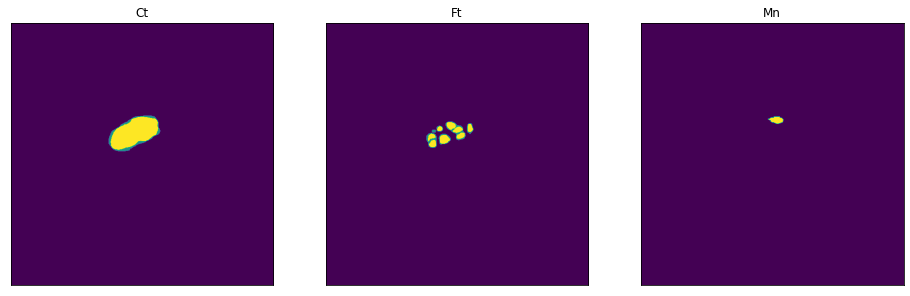

picture =  16
CT IoU  Score = 0.7304763591287409
CT Dice Score = 0.8442488743348342
FT IoU  Score = 0.7511825922421949
FT Dice Score = 0.857914640734738
MN IoU  Score = 0.0
MN Dice Score = 0.0


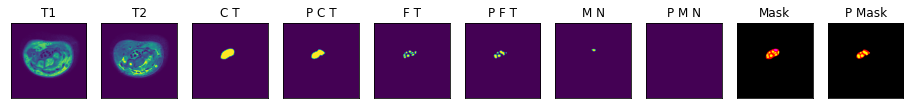

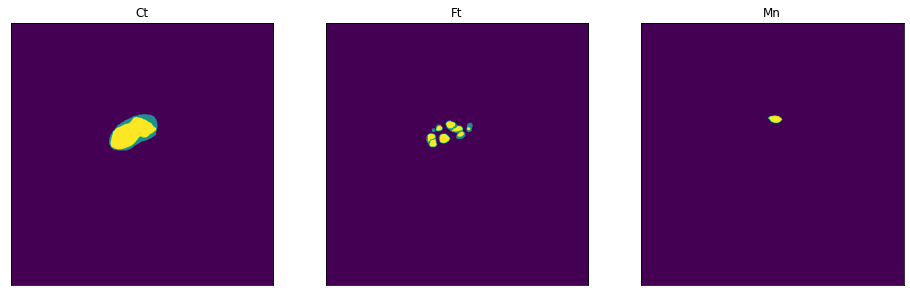

picture =  17
CT IoU  Score = 0.7866575201509175
CT Dice Score = 0.8805912843156076
FT IoU  Score = 0.7783086478738652
FT Dice Score = 0.8753358409457281
MN IoU  Score = 0.0
MN Dice Score = 0.0


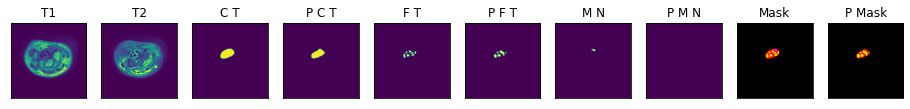

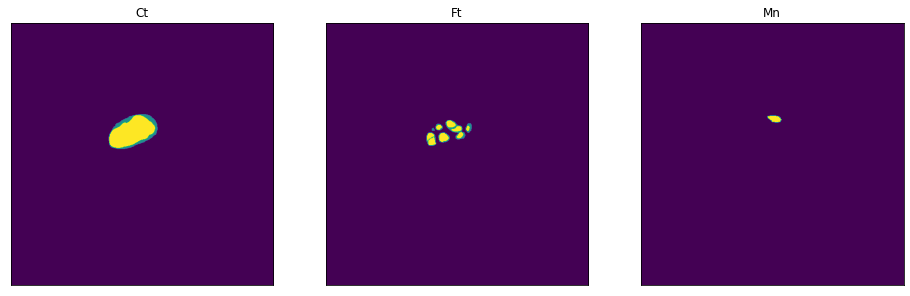

fold =  3
picture =  0
CT IoU  Score = 0.7099821990962618
CT Dice Score = 0.8303971812940423
FT IoU  Score = 0.7720446669233731
FT Dice Score = 0.8713602781399391
MN IoU  Score = 0.0
MN Dice Score = 0.0


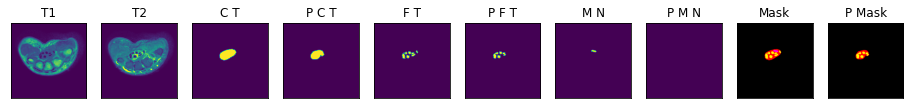

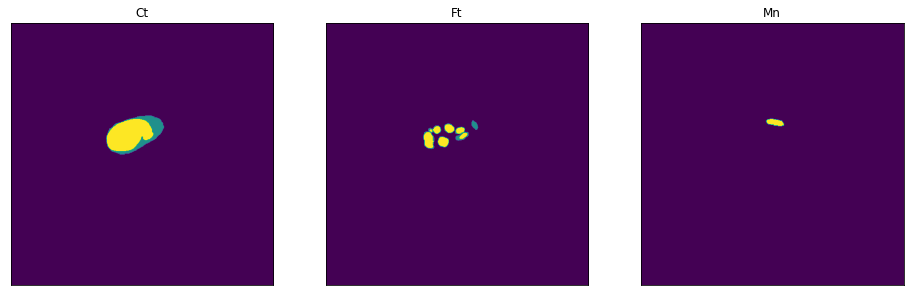

picture =  1
CT IoU  Score = 0.7575081772227178
CT Dice Score = 0.8620252093731495
FT IoU  Score = 0.8441210264266564
FT Dice Score = 0.915472481827622
MN IoU  Score = 0.054187192118226604
MN Dice Score = 0.102803738317757


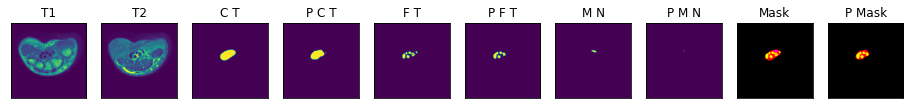

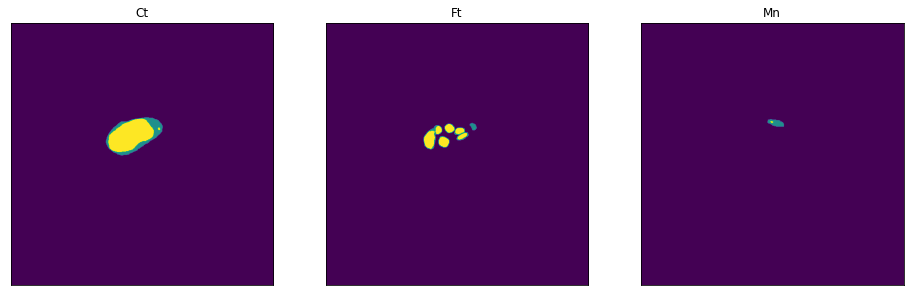

picture =  2
CT IoU  Score = 0.7902869757174393
CT Dice Score = 0.8828606658446363
FT IoU  Score = 0.8091168091168092
FT Dice Score = 0.8944881889763779
MN IoU  Score = 0.0
MN Dice Score = 0.0


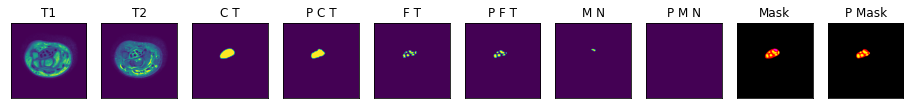

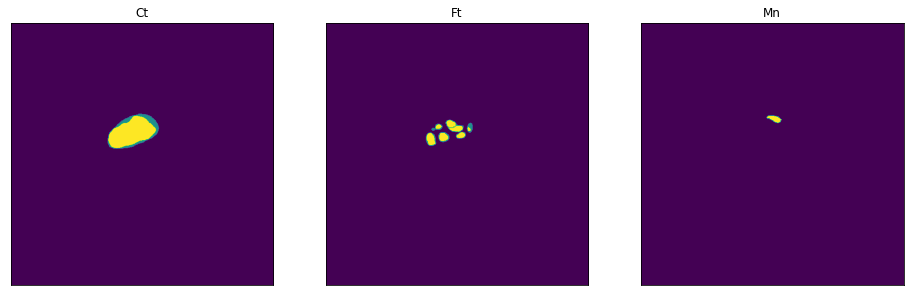

picture =  3
CT IoU  Score = 0.8873483535528596
CT Dice Score = 0.9403122130394858
FT IoU  Score = 0.8639423076923077
FT Dice Score = 0.9270054165591952
MN IoU  Score = 0.0
MN Dice Score = 0.0


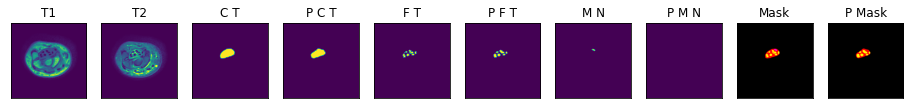

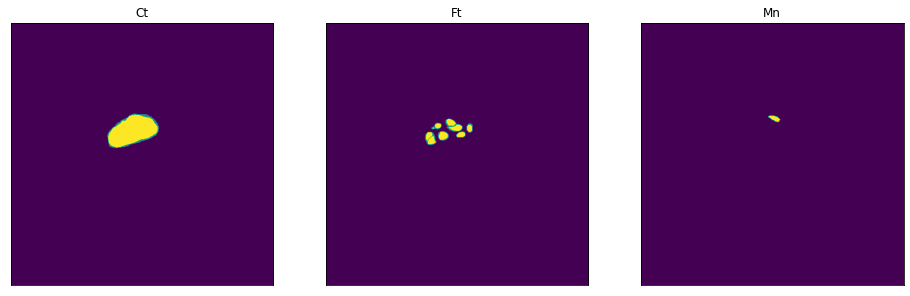

picture =  4
CT IoU  Score = 0.9167348274169802
CT Dice Score = 0.9565588461210207
FT IoU  Score = 0.8689458689458689
FT Dice Score = 0.9298780487804879
MN IoU  Score = 0.0
MN Dice Score = 0.0


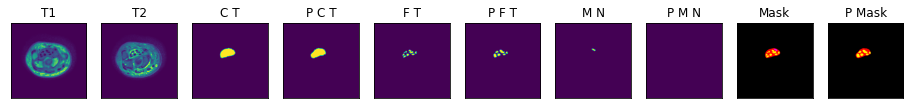

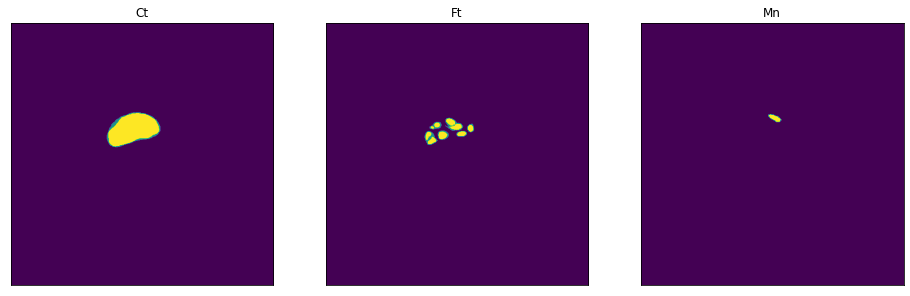

picture =  5
CT IoU  Score = 0.9193667702322829
CT Dice Score = 0.9579896708548524
FT IoU  Score = 0.8771626297577855
FT Dice Score = 0.9345622119815669
MN IoU  Score = 0.0
MN Dice Score = 0.0


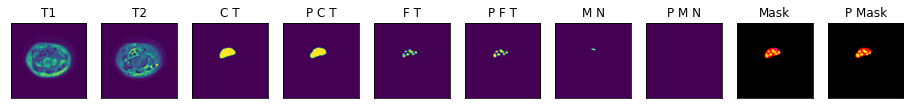

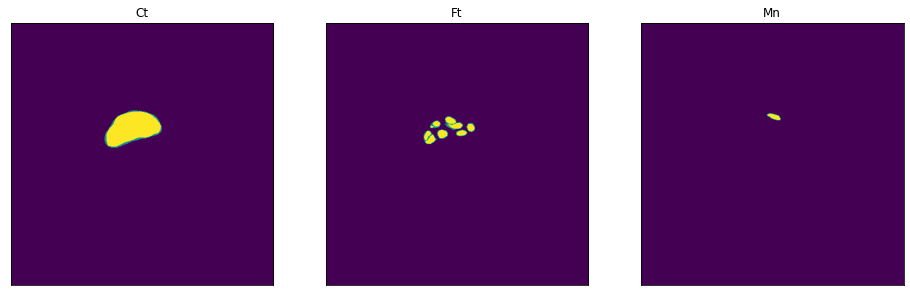

picture =  6
CT IoU  Score = 0.9352727272727273
CT Dice Score = 0.966553927095077
FT IoU  Score = 0.8831111111111111
FT Dice Score = 0.9379277790889781
MN IoU  Score = 0.0
MN Dice Score = 0.0


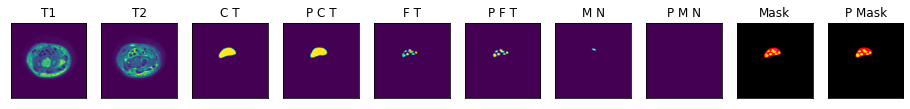

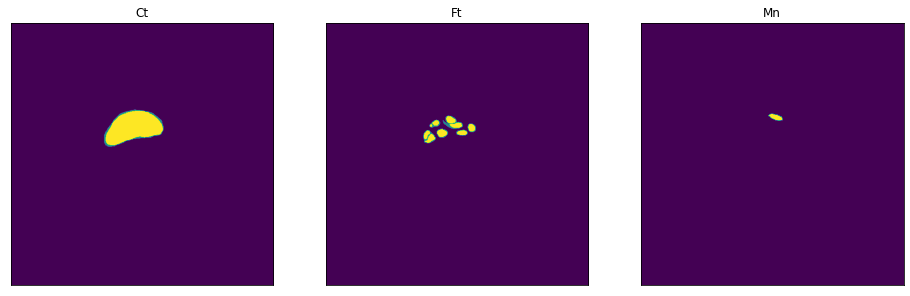

picture =  7
CT IoU  Score = 0.7935645633096532
CT Dice Score = 0.8849021435228331
FT IoU  Score = 0.8294573643410853
FT Dice Score = 0.9067796610169492
MN IoU  Score = 0.0
MN Dice Score = 0.0


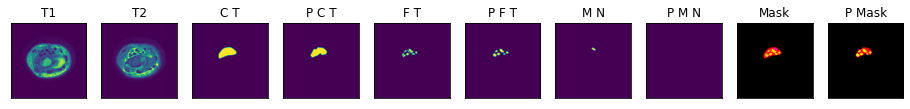

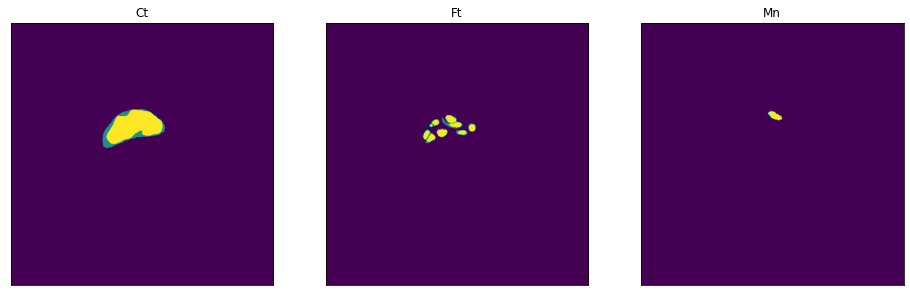

picture =  8
CT IoU  Score = 0.7740955537144435
CT Dice Score = 0.8726650062266501
FT IoU  Score = 0.768122085629504
FT Dice Score = 0.8688563893550707
MN IoU  Score = 0.0
MN Dice Score = 0.0


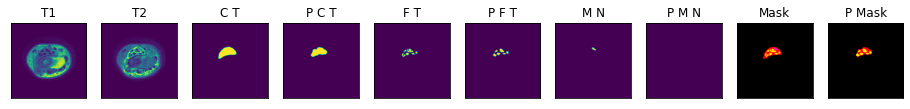

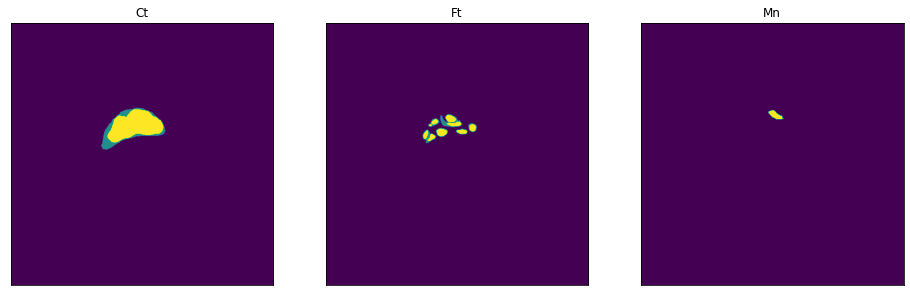

picture =  9
CT IoU  Score = 0.7681656504065041
CT Dice Score = 0.868884258926647
FT IoU  Score = 0.6943487250172296
FT Dice Score = 0.8196054504779337
MN IoU  Score = 0.0
MN Dice Score = 0.0


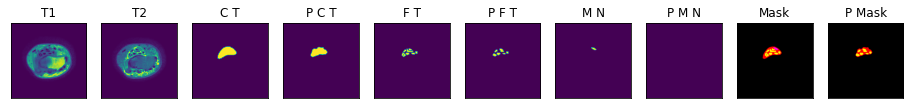

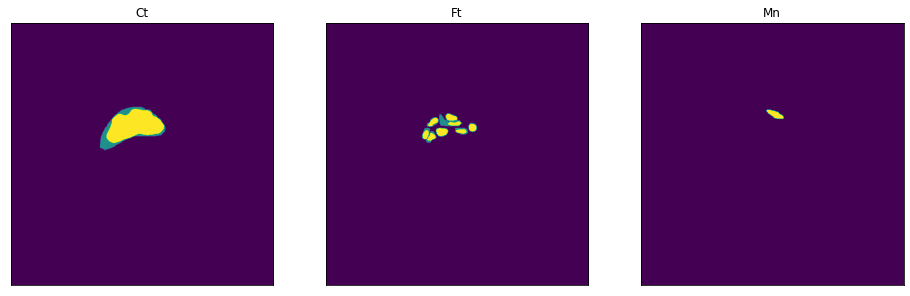

picture =  10
CT IoU  Score = 0.8225024248302619
CT Dice Score = 0.9026077700904737
FT IoU  Score = 0.8614751029576937
FT Dice Score = 0.9255832662912309
MN IoU  Score = 0.0
MN Dice Score = 0.0


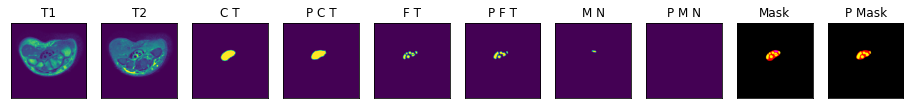

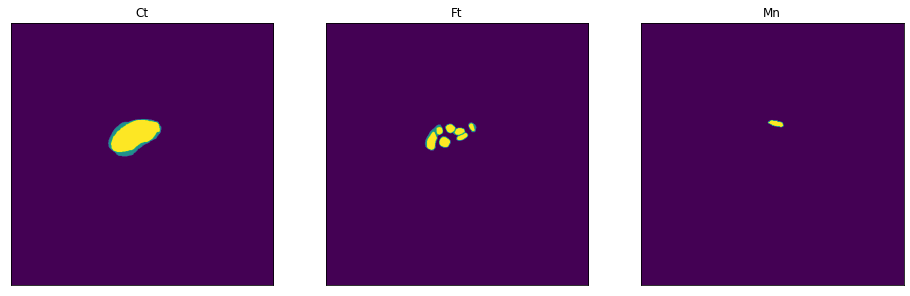

picture =  11
CT IoU  Score = 0.8840980283766353
CT Dice Score = 0.9384841075794621
FT IoU  Score = 0.8521183053557154
FT Dice Score = 0.9201553733275788
MN IoU  Score = 0.0
MN Dice Score = 0.0


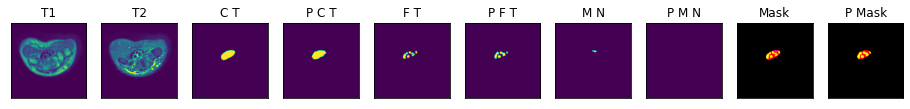

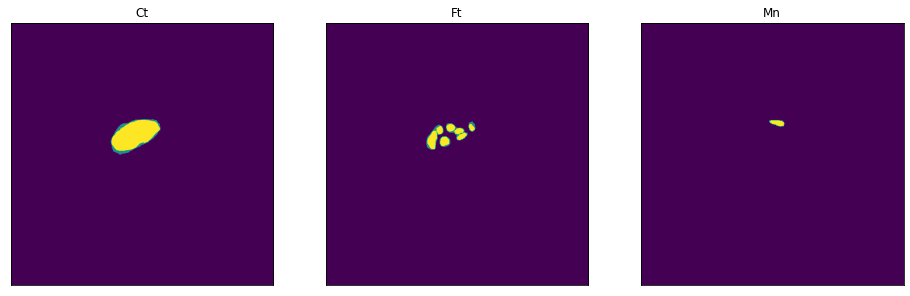

picture =  12
CT IoU  Score = 0.8143009605122732
CT Dice Score = 0.8976470588235295
FT IoU  Score = 0.8737745098039216
FT Dice Score = 0.9326357096141269
MN IoU  Score = 0.0
MN Dice Score = 0.0


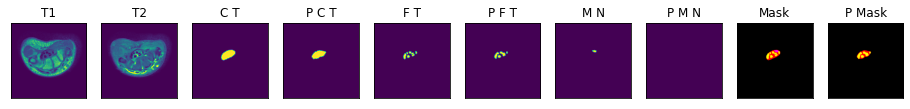

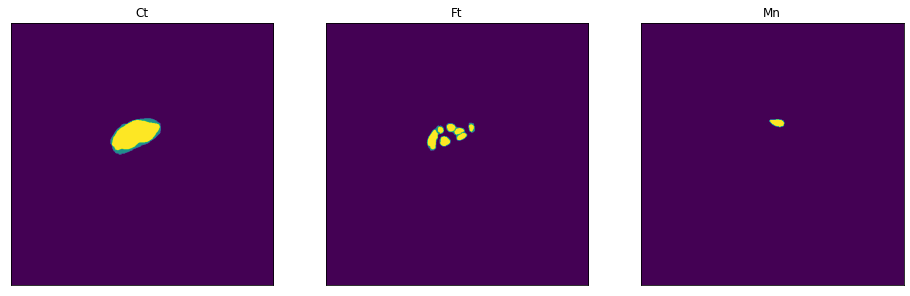

picture =  13
CT IoU  Score = 0.8265656018769175
CT Dice Score = 0.9050489082106511
FT IoU  Score = 0.8712389380530974
FT Dice Score = 0.9311894064790731
MN IoU  Score = 0.0
MN Dice Score = 0.0


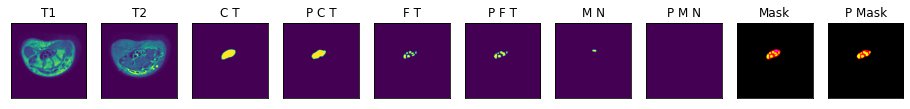

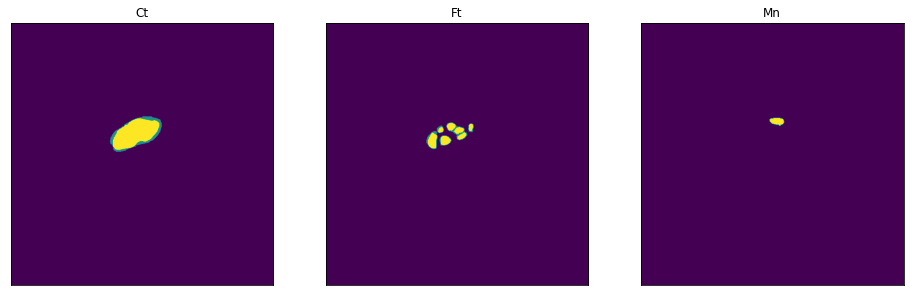

picture =  14
CT IoU  Score = 0.8009514747859182
CT Dice Score = 0.8894759087066779
FT IoU  Score = 0.7966636609558161
FT Dice Score = 0.8868255959849436
MN IoU  Score = 0.0
MN Dice Score = 0.0


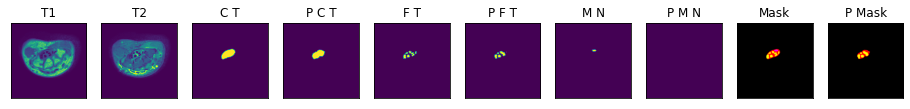

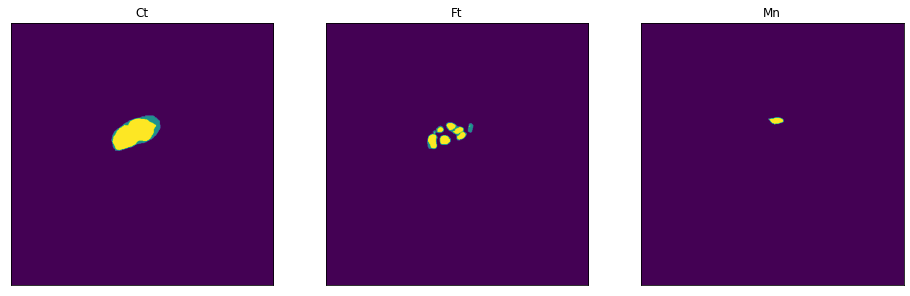

picture =  15
CT IoU  Score = 0.8856191977579261
CT Dice Score = 0.9393404551788203
FT IoU  Score = 0.821664464993395
FT Dice Score = 0.902102973168963
MN IoU  Score = 0.0
MN Dice Score = 0.0


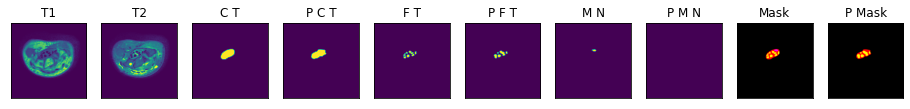

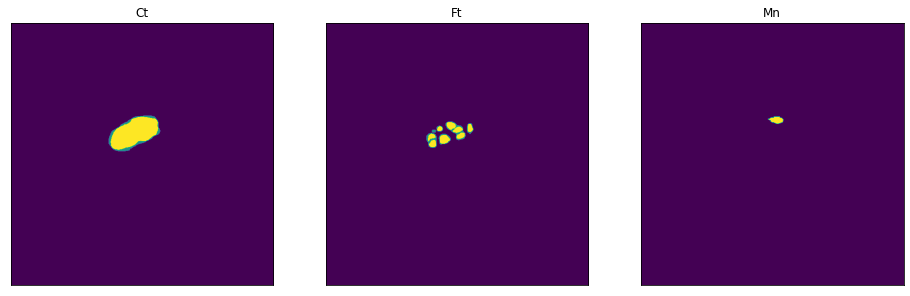

picture =  16
CT IoU  Score = 0.7304763591287409
CT Dice Score = 0.8442488743348342
FT IoU  Score = 0.7511825922421949
FT Dice Score = 0.857914640734738
MN IoU  Score = 0.0
MN Dice Score = 0.0


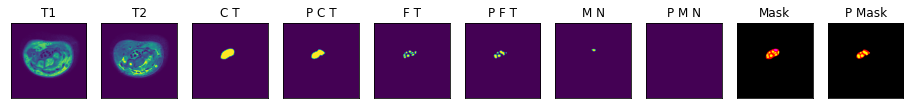

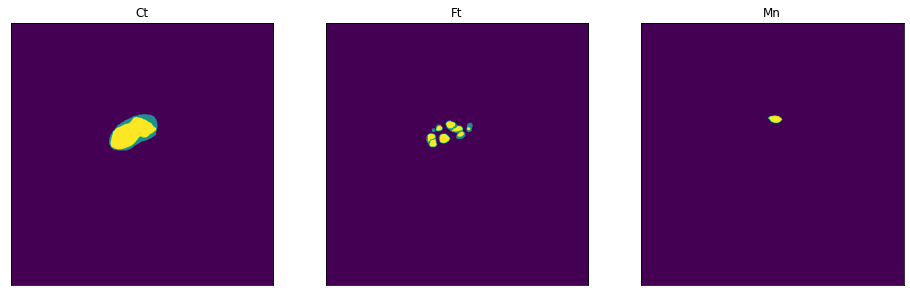

picture =  17
CT IoU  Score = 0.7866575201509175
CT Dice Score = 0.8805912843156076
FT IoU  Score = 0.7783086478738652
FT Dice Score = 0.8753358409457281
MN IoU  Score = 0.0
MN Dice Score = 0.0


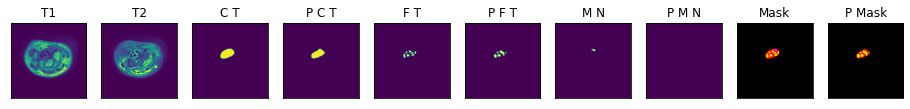

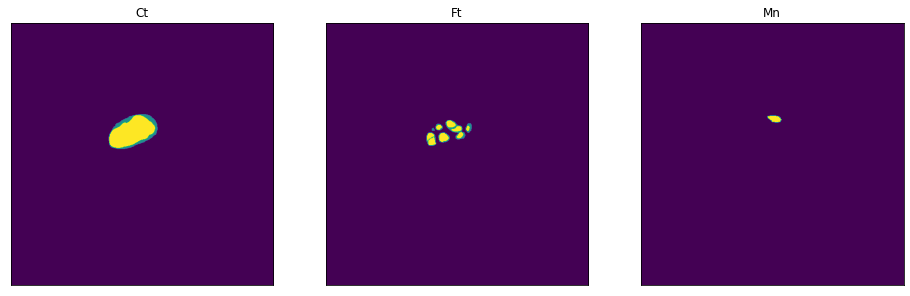

fold =  4
picture =  0
CT IoU  Score = 0.7099821990962618
CT Dice Score = 0.8303971812940423
FT IoU  Score = 0.7720446669233731
FT Dice Score = 0.8713602781399391
MN IoU  Score = 0.0
MN Dice Score = 0.0


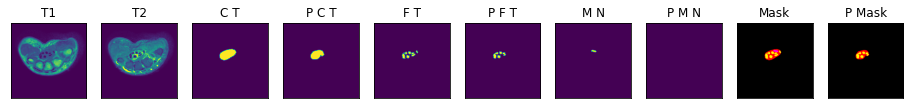

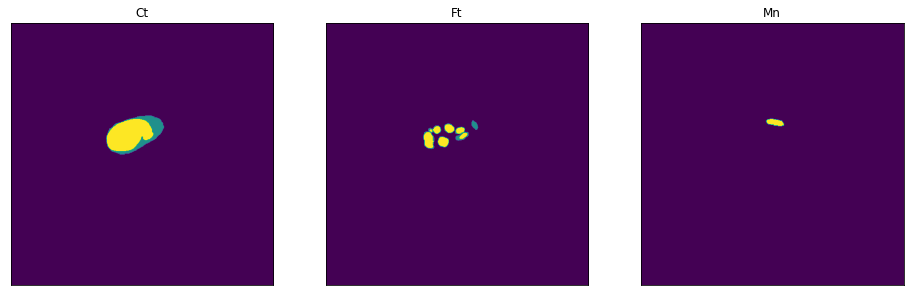

picture =  1
CT IoU  Score = 0.7575081772227178
CT Dice Score = 0.8620252093731495
FT IoU  Score = 0.8441210264266564
FT Dice Score = 0.915472481827622
MN IoU  Score = 0.054187192118226604
MN Dice Score = 0.102803738317757


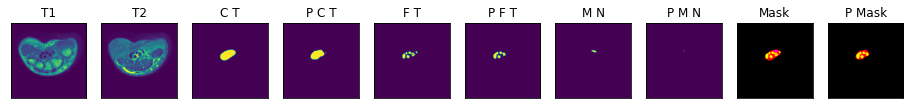

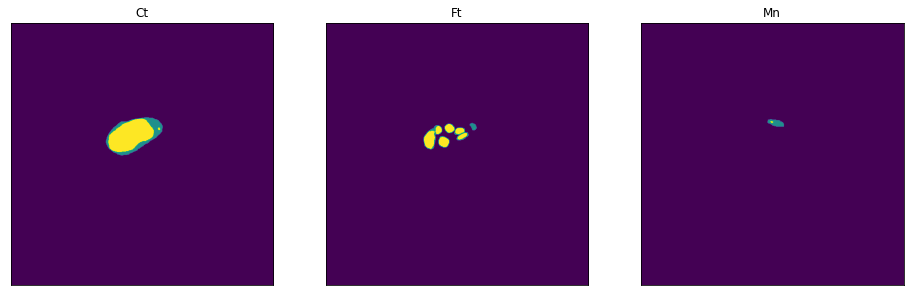

picture =  2
CT IoU  Score = 0.7902869757174393
CT Dice Score = 0.8828606658446363
FT IoU  Score = 0.8091168091168092
FT Dice Score = 0.8944881889763779
MN IoU  Score = 0.0
MN Dice Score = 0.0


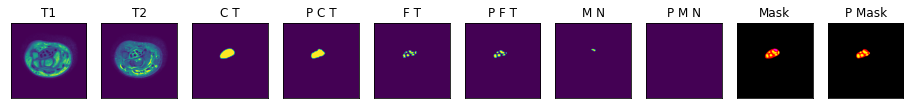

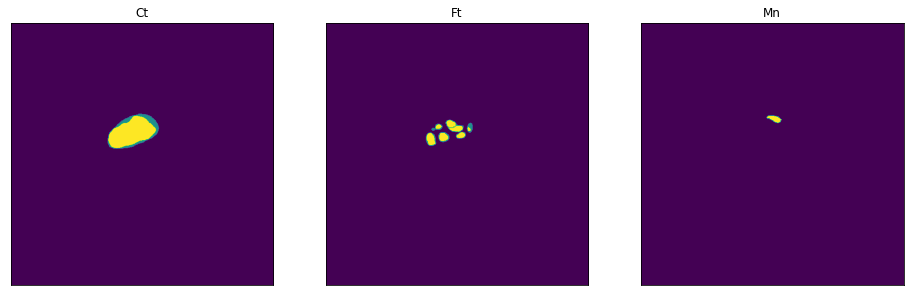

picture =  3
CT IoU  Score = 0.8873483535528596
CT Dice Score = 0.9403122130394858
FT IoU  Score = 0.8639423076923077
FT Dice Score = 0.9270054165591952
MN IoU  Score = 0.0
MN Dice Score = 0.0


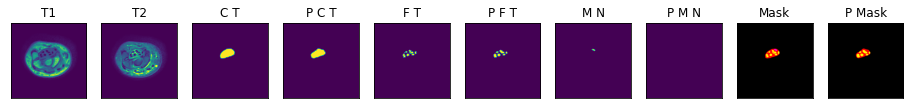

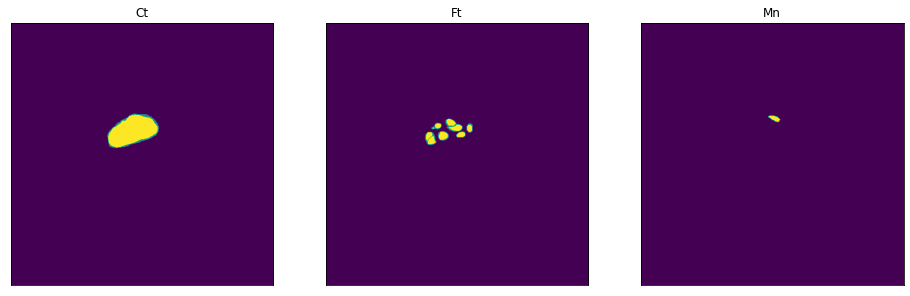

picture =  4
CT IoU  Score = 0.9167348274169802
CT Dice Score = 0.9565588461210207
FT IoU  Score = 0.8689458689458689
FT Dice Score = 0.9298780487804879
MN IoU  Score = 0.0
MN Dice Score = 0.0


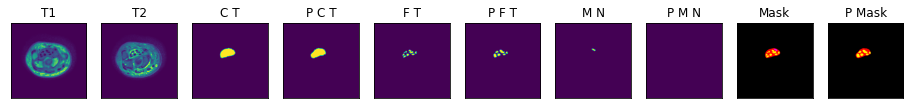

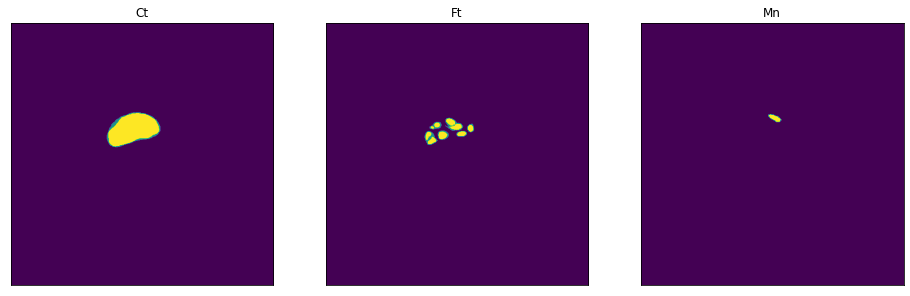

picture =  5
CT IoU  Score = 0.9193667702322829
CT Dice Score = 0.9579896708548524
FT IoU  Score = 0.8771626297577855
FT Dice Score = 0.9345622119815669
MN IoU  Score = 0.0
MN Dice Score = 0.0


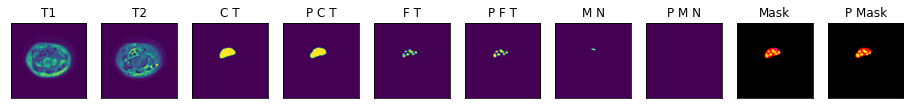

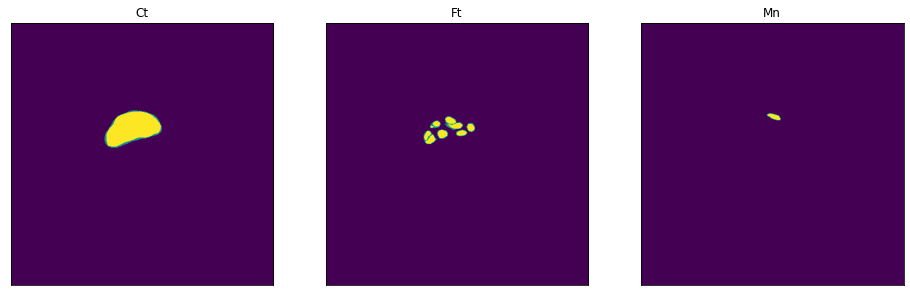

picture =  6
CT IoU  Score = 0.9352727272727273
CT Dice Score = 0.966553927095077
FT IoU  Score = 0.8831111111111111
FT Dice Score = 0.9379277790889781
MN IoU  Score = 0.0
MN Dice Score = 0.0


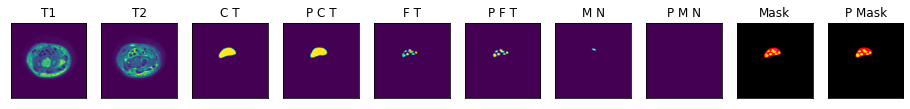

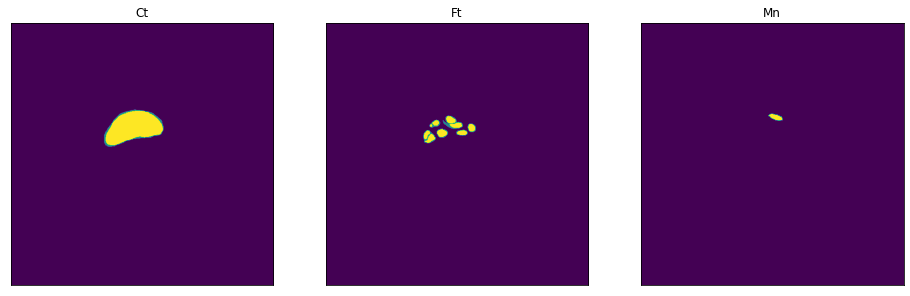

picture =  7
CT IoU  Score = 0.7935645633096532
CT Dice Score = 0.8849021435228331
FT IoU  Score = 0.8294573643410853
FT Dice Score = 0.9067796610169492
MN IoU  Score = 0.0
MN Dice Score = 0.0


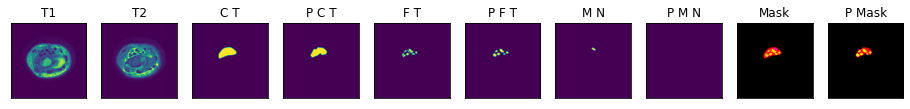

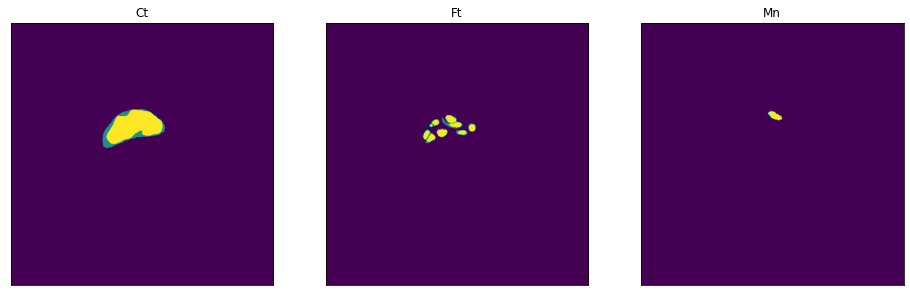

picture =  8
CT IoU  Score = 0.7740955537144435
CT Dice Score = 0.8726650062266501
FT IoU  Score = 0.768122085629504
FT Dice Score = 0.8688563893550707
MN IoU  Score = 0.0
MN Dice Score = 0.0


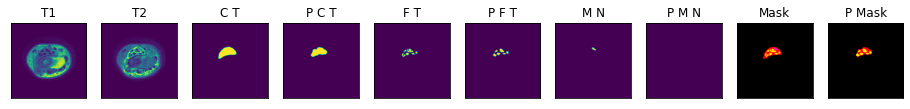

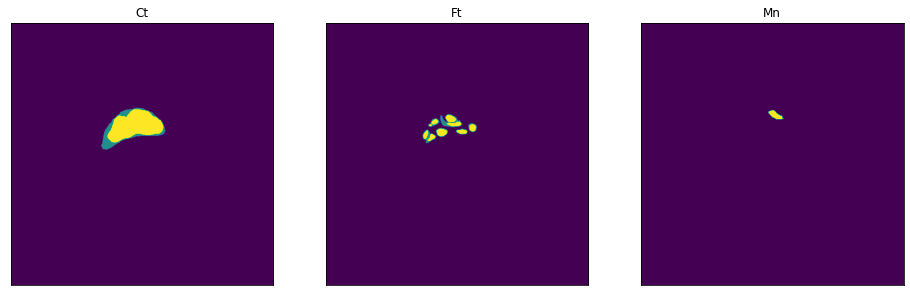

picture =  9
CT IoU  Score = 0.7681656504065041
CT Dice Score = 0.868884258926647
FT IoU  Score = 0.6943487250172296
FT Dice Score = 0.8196054504779337
MN IoU  Score = 0.0
MN Dice Score = 0.0


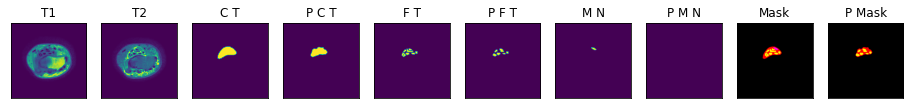

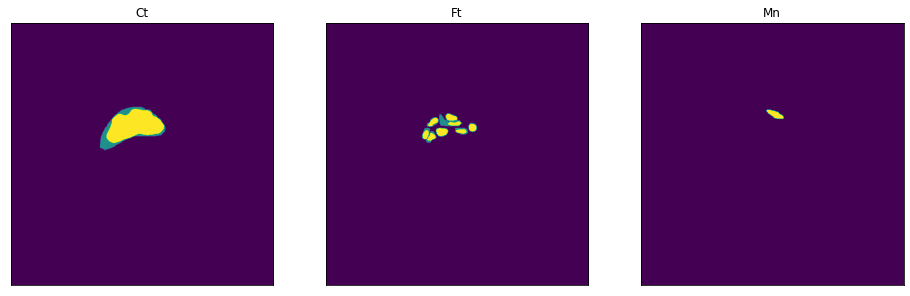

picture =  10
CT IoU  Score = 0.8225024248302619
CT Dice Score = 0.9026077700904737
FT IoU  Score = 0.8614751029576937
FT Dice Score = 0.9255832662912309
MN IoU  Score = 0.0
MN Dice Score = 0.0


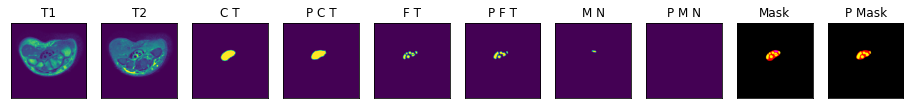

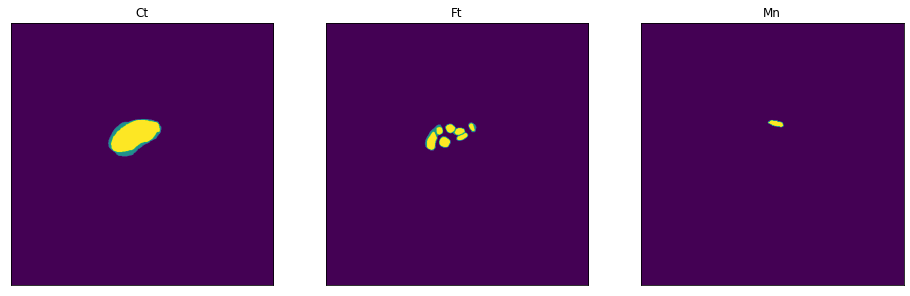

picture =  11
CT IoU  Score = 0.8840980283766353
CT Dice Score = 0.9384841075794621
FT IoU  Score = 0.8521183053557154
FT Dice Score = 0.9201553733275788
MN IoU  Score = 0.0
MN Dice Score = 0.0


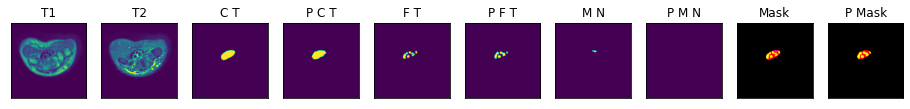

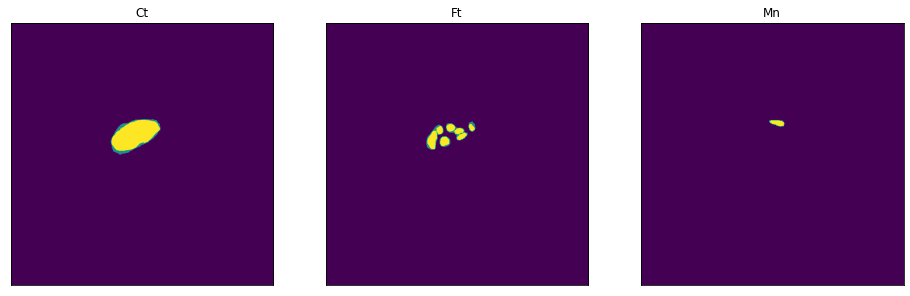

picture =  12
CT IoU  Score = 0.8143009605122732
CT Dice Score = 0.8976470588235295
FT IoU  Score = 0.8737745098039216
FT Dice Score = 0.9326357096141269
MN IoU  Score = 0.0
MN Dice Score = 0.0


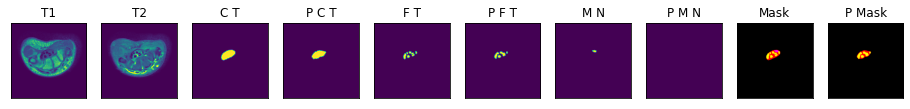

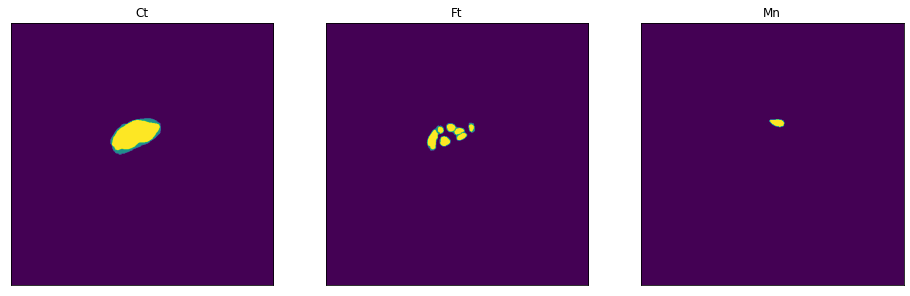

picture =  13
CT IoU  Score = 0.8265656018769175
CT Dice Score = 0.9050489082106511
FT IoU  Score = 0.8712389380530974
FT Dice Score = 0.9311894064790731
MN IoU  Score = 0.0
MN Dice Score = 0.0


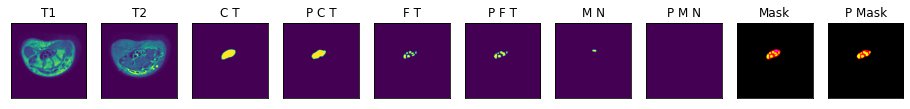

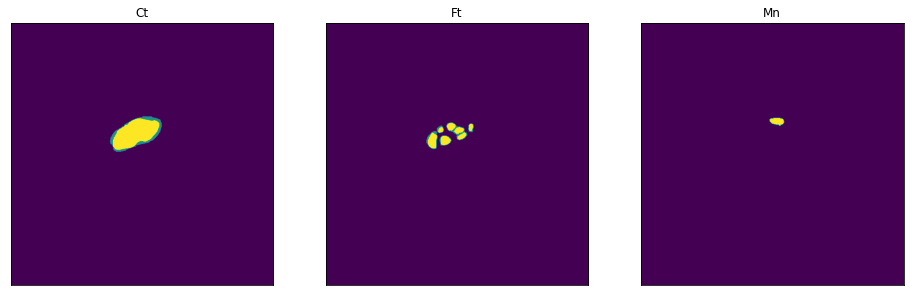

picture =  14
CT IoU  Score = 0.8009514747859182
CT Dice Score = 0.8894759087066779
FT IoU  Score = 0.7966636609558161
FT Dice Score = 0.8868255959849436
MN IoU  Score = 0.0
MN Dice Score = 0.0


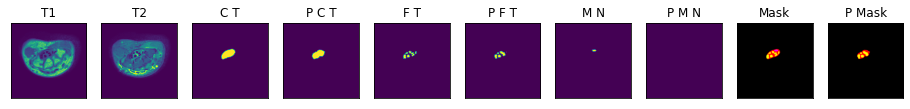

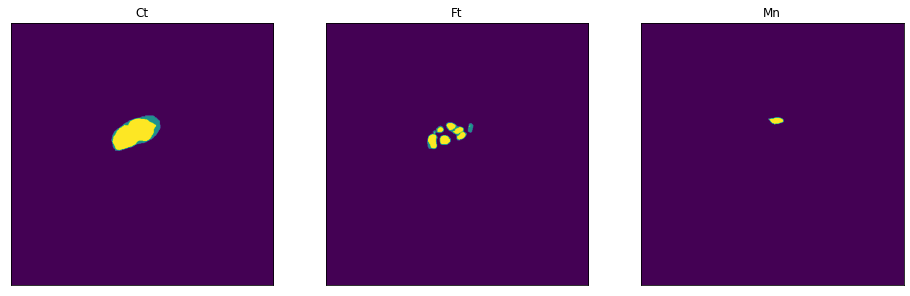

picture =  15
CT IoU  Score = 0.8856191977579261
CT Dice Score = 0.9393404551788203
FT IoU  Score = 0.821664464993395
FT Dice Score = 0.902102973168963
MN IoU  Score = 0.0
MN Dice Score = 0.0


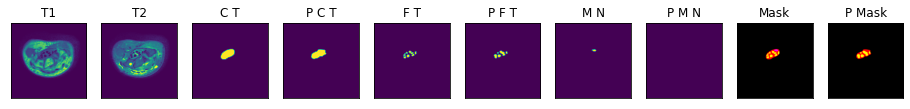

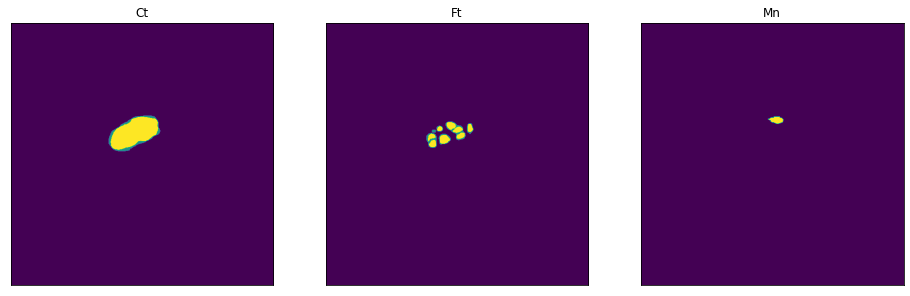

picture =  16
CT IoU  Score = 0.7304763591287409
CT Dice Score = 0.8442488743348342
FT IoU  Score = 0.7511825922421949
FT Dice Score = 0.857914640734738
MN IoU  Score = 0.0
MN Dice Score = 0.0


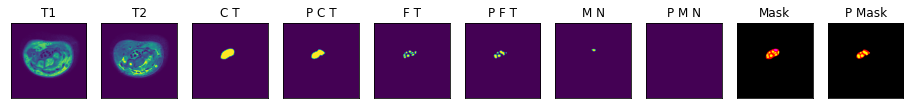

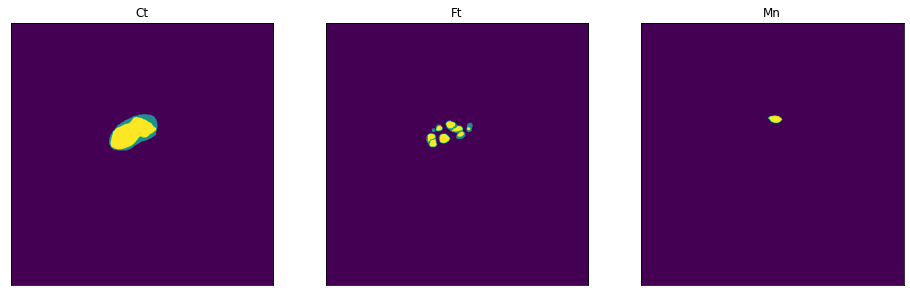

picture =  17
CT IoU  Score = 0.7866575201509175
CT Dice Score = 0.8805912843156076
FT IoU  Score = 0.7783086478738652
FT Dice Score = 0.8753358409457281
MN IoU  Score = 0.0
MN Dice Score = 0.0


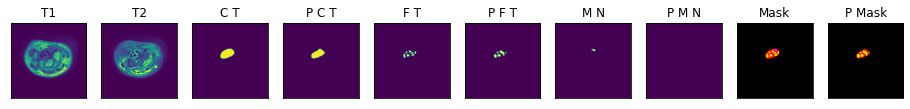

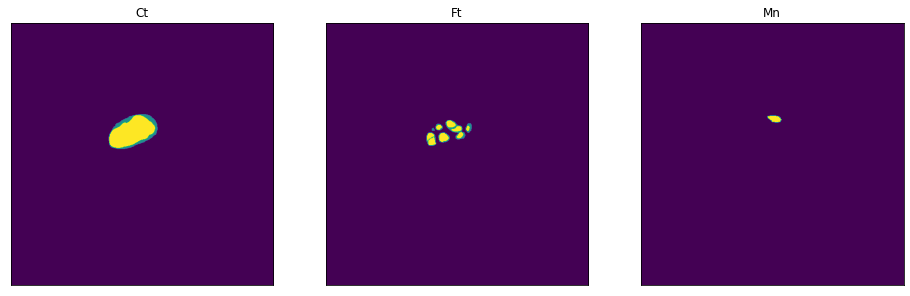

In [226]:
TestSet_f = Dataset(
              image_path = {"T1":Test_T1, "T2":Test_T2},
              masks_path = {"CT":Test_CT, "FT":Test_FT, "MN":Test_MN},
              preprocessing=get_preprocessing(),
)
for fold in range(0,5):
  print("fold = ",fold)
  for n in range(len(TestSet_f)):
    print("picture = ",n)
    image_vis = TestSet_f[n][0].astype('uint8')
    image, gt_mask = TestSet[n]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    best_model[fold][0].eval()
    pr_mask = best_model[fold][0].predict(x_tensor)
    pr_mask = (pr_mask.cpu().numpy().round())
    CT = IoU_2D(gt_mask[0],pr_mask[0,0])
    FT = IoU_2D(gt_mask[1],pr_mask[0,1])
    MN = IoU_2D(gt_mask[2],pr_mask[0,2])
    print("CT IoU  Score = {}".format(CT[0]))
    print("CT Dice Score = {}".format(CT[1]))
    print("FT IoU  Score = {}".format(FT[0]))
    print("FT Dice Score = {}".format(FT[1]))
    print("MN IoU  Score = {}".format(MN[0]))
    print("MN Dice Score = {}".format(MN[1]))

    mask = np.transpose(gt_mask,(1,2,0))
    pmask = np.transpose(pr_mask[0],(1,2,0))
    visualize(
      T1 = image[0],
      T2 = image[1],
      C_T = gt_mask[0].squeeze(),
      P_C_T = pr_mask[0,0,:,:].squeeze(),
      F_T = gt_mask[1].squeeze(),
      P_F_T = pr_mask[0,1,:,:].squeeze(),
      M_N = gt_mask[2].squeeze(),
      P_M_N = pr_mask[0,2,:,:].squeeze(),
      Mask = mask,
      P_Mask = pmask
    )
    visualize(
        CT = ((gt_mask[0] + pr_mask[0,0,:,:])/2).squeeze(),
        FT = ((gt_mask[1] + pr_mask[0,1,:,:])/2).squeeze(),
        MN = ((gt_mask[2] + pr_mask[0,2,:,:])/2).squeeze()
    )